<a href="https://colab.research.google.com/github/jackrlynn3/capstone-diabetes/blob/main/models/diabetes_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deep Learning (DL)** Approach to **Predict Blood Glucose Sharp Peaking** in Diabetes Patients

In [1]:
# Downloads
! pip install pymssql

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
# Imports
import numpy as np
import pymssql
import pandas as pd
import matplotlib.pyplot as plt
from getpass import getpass
import datetime as dt
from datetime import timedelta
from scipy.signal import savgol_filter, find_peaks
import time
import random as r

### **Part 1:** Set-Up of Dataset
*Contact Jack Lynn (jackrlynn@gmail.com) for log-in credentials.*

In [4]:
# Get dataset
def getData(database, table, server, port):

    # Get username and password
    username = input('Please enter username: ')
    password = getpass('Please enter password: ')

    conn = pymssql.connect(server,username,password,database)
    cursor = conn.cursor()
    query = f"SELECT * FROM {table}"
    df = pd.read_sql(query,conn)
    return df

df = getData("group5database", "dbo.GlucoseMeter",
             "gen10-data-fundamentals-22-05-sql-server.database.windows.net",
             "1433")

Please enter username: jacklynn
Please enter password: ··········


Text(0, 0.5, 'Blood Glucoose (mmol/L)')

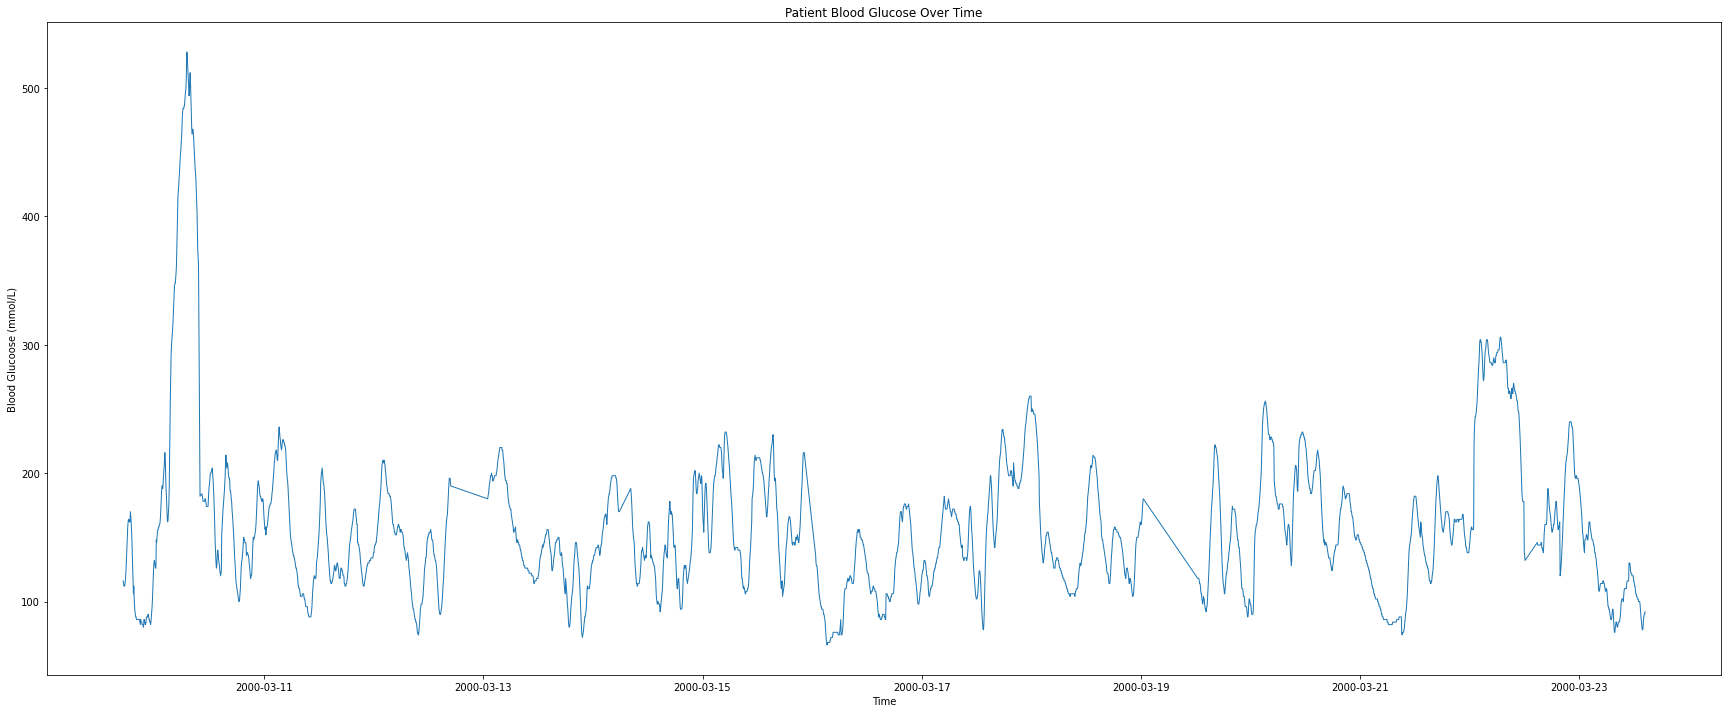

In [5]:
# Display static graphs
%matplotlib inline

# Get each patient
pts = dict()
for ptID in df['ptID'].unique():
  this_df = df[df['ptID'] == ptID]

  # Get only data related to time and glucose_lvl
  this_df = this_df[['time', 'glucose_lvl']]

  # Convert time back into dateime format
  this_df['time']= pd.to_datetime(this_df['time'])

  # Make sure time is in order
  this_df = this_df.sort_values('time')

  # Add patient to dictionary
  pts[ptID] = this_df

# Plot each patient on the same graph
fig, ax = plt.subplots(figsize=(30, 12))
ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1)
ax.set_title('Patient Blood Glucose Over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Blood Glucoose (mmol/L)')

### **Part 2:** Apply Savitsky-Golay Filter to Reduce Noise

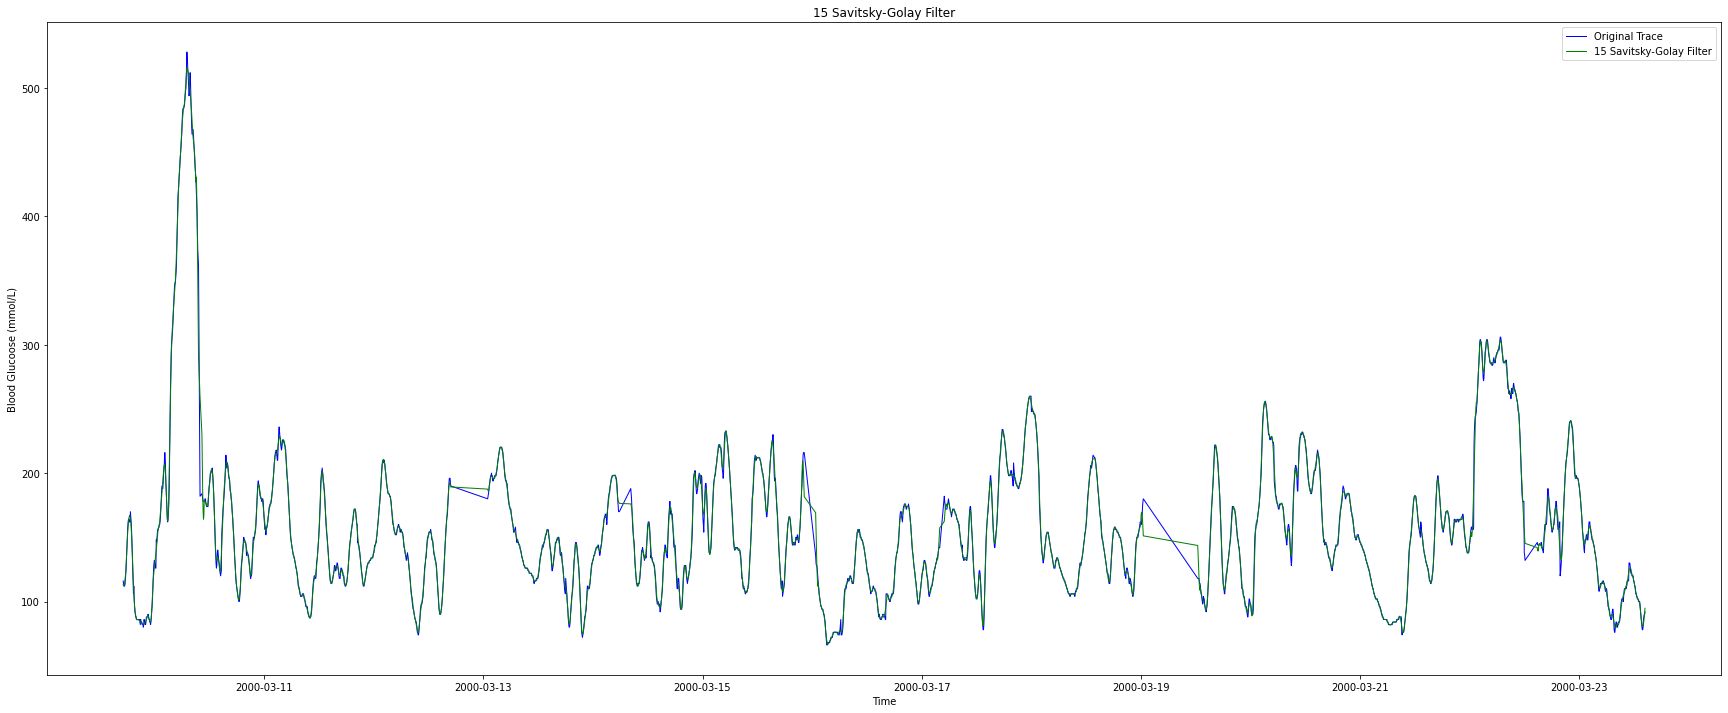

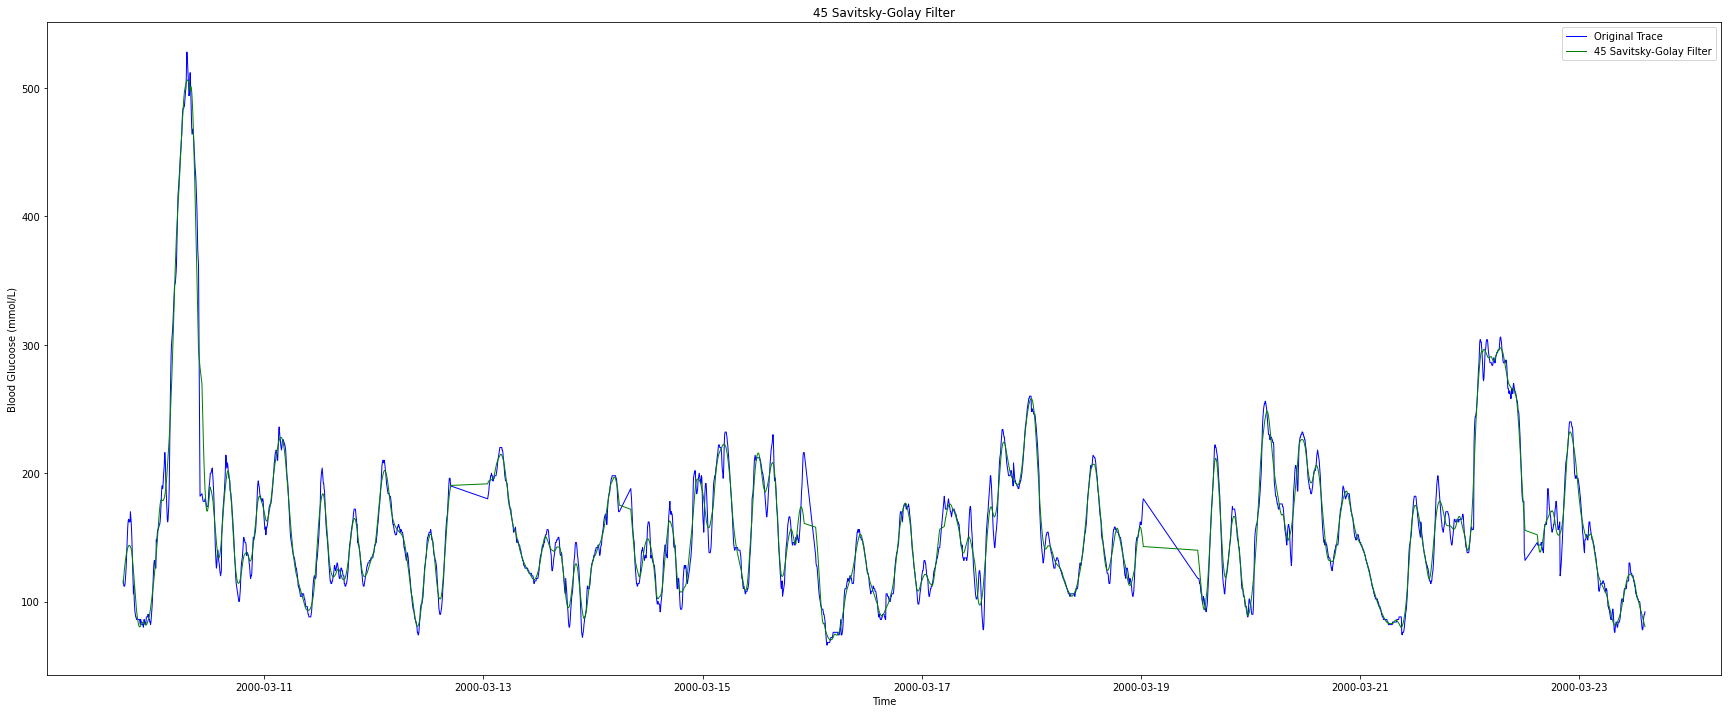

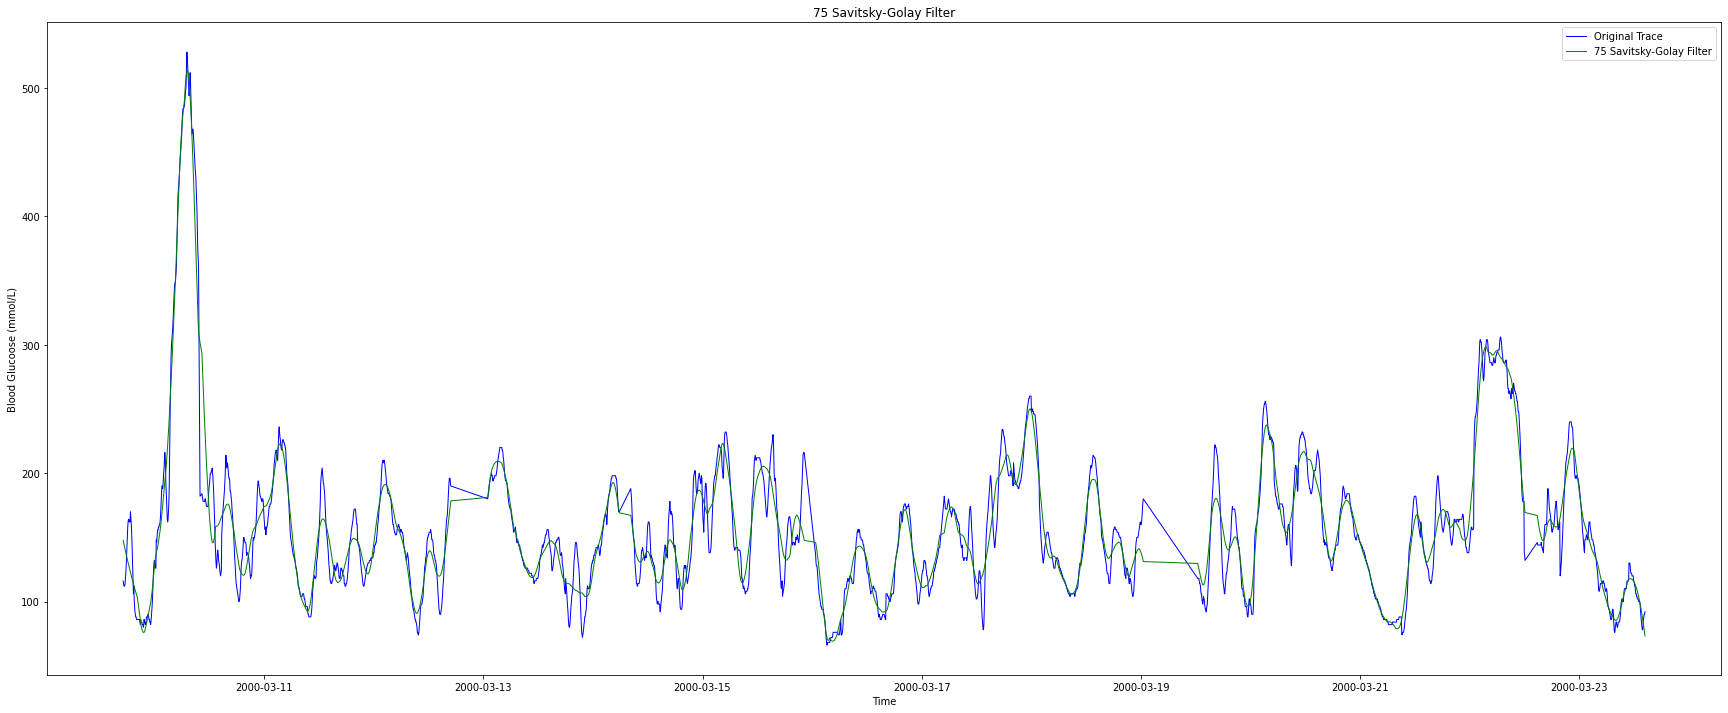

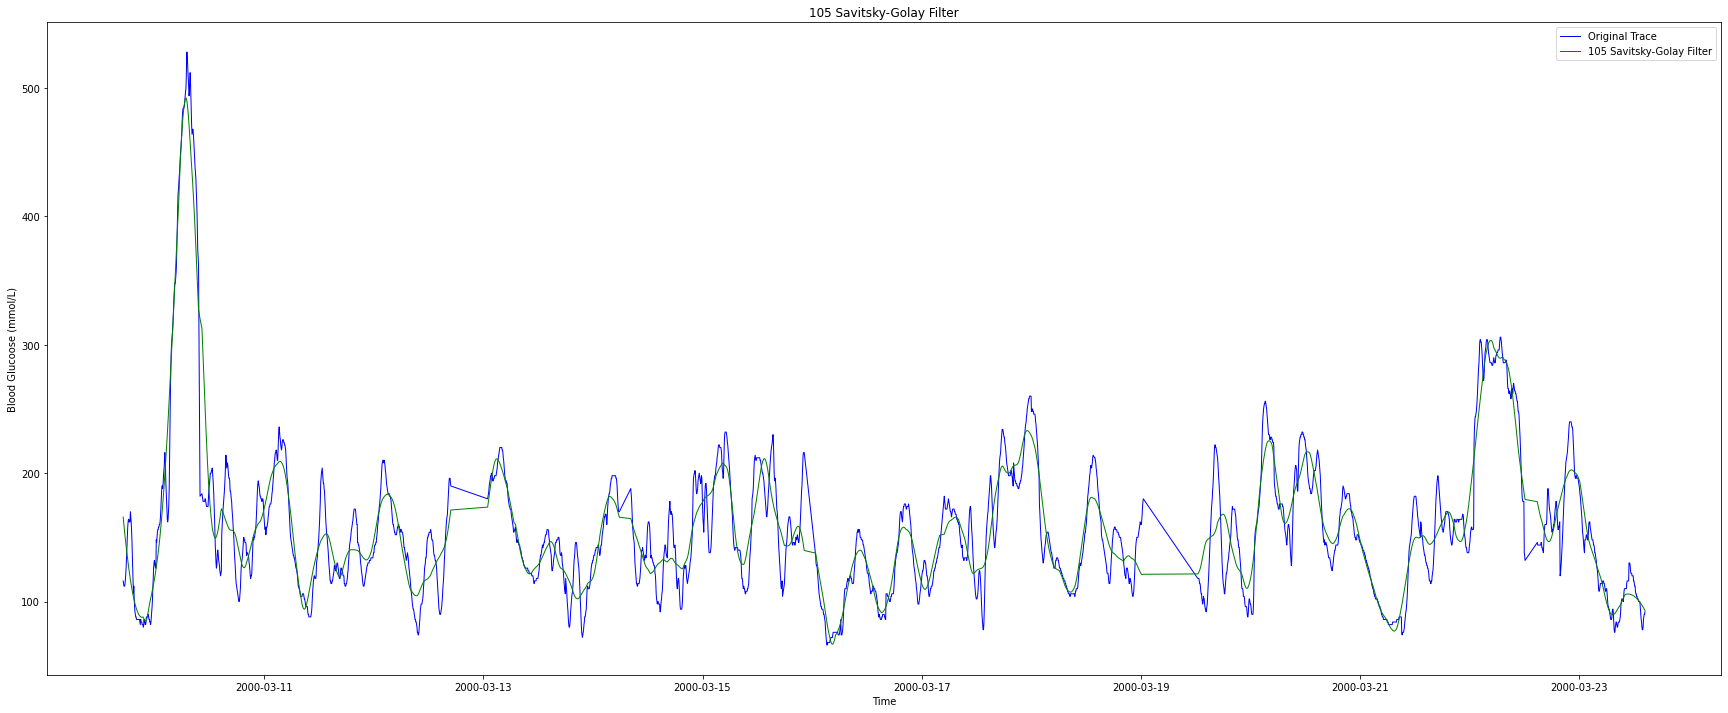

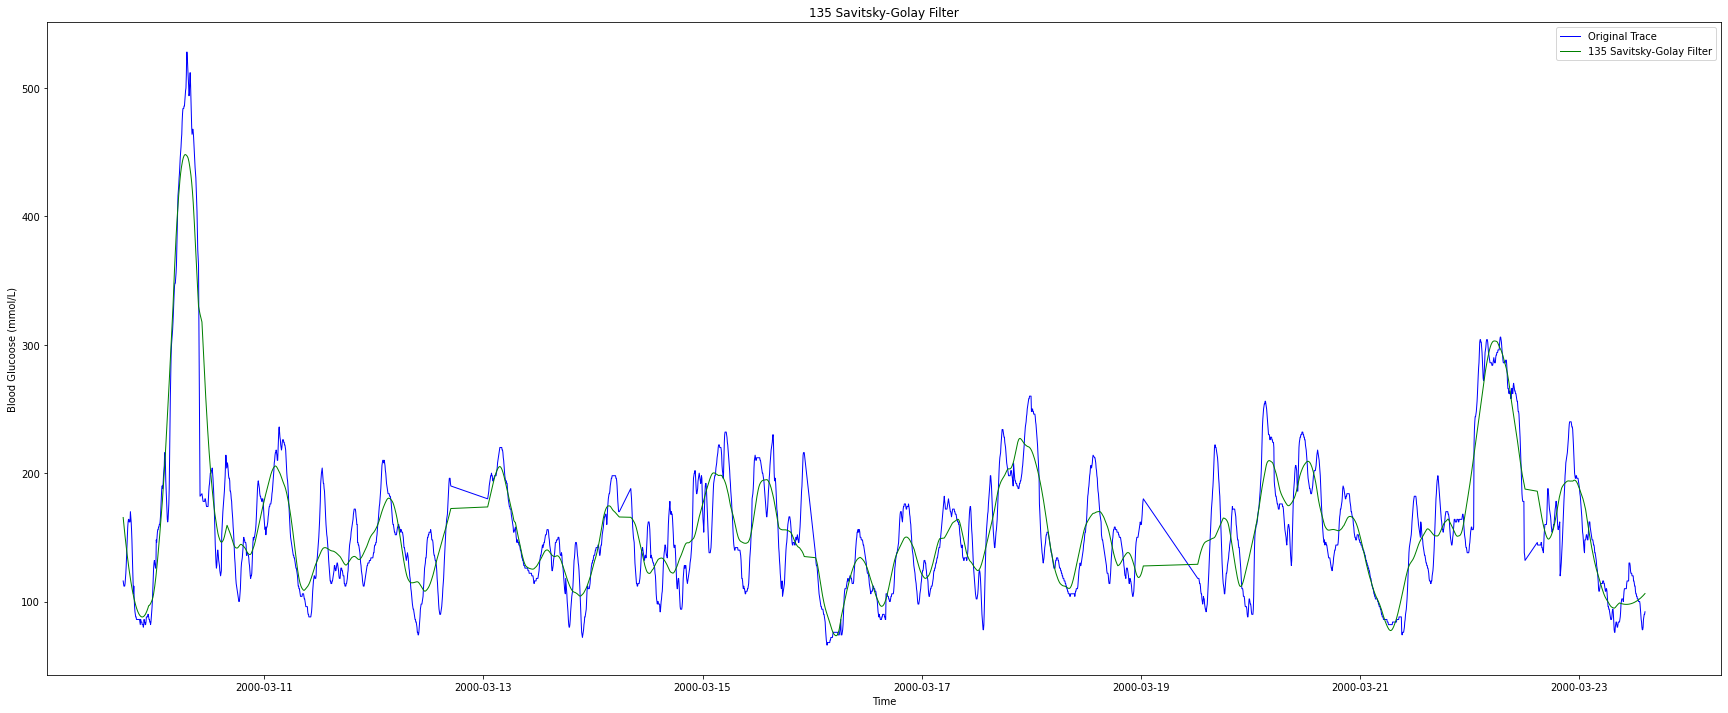

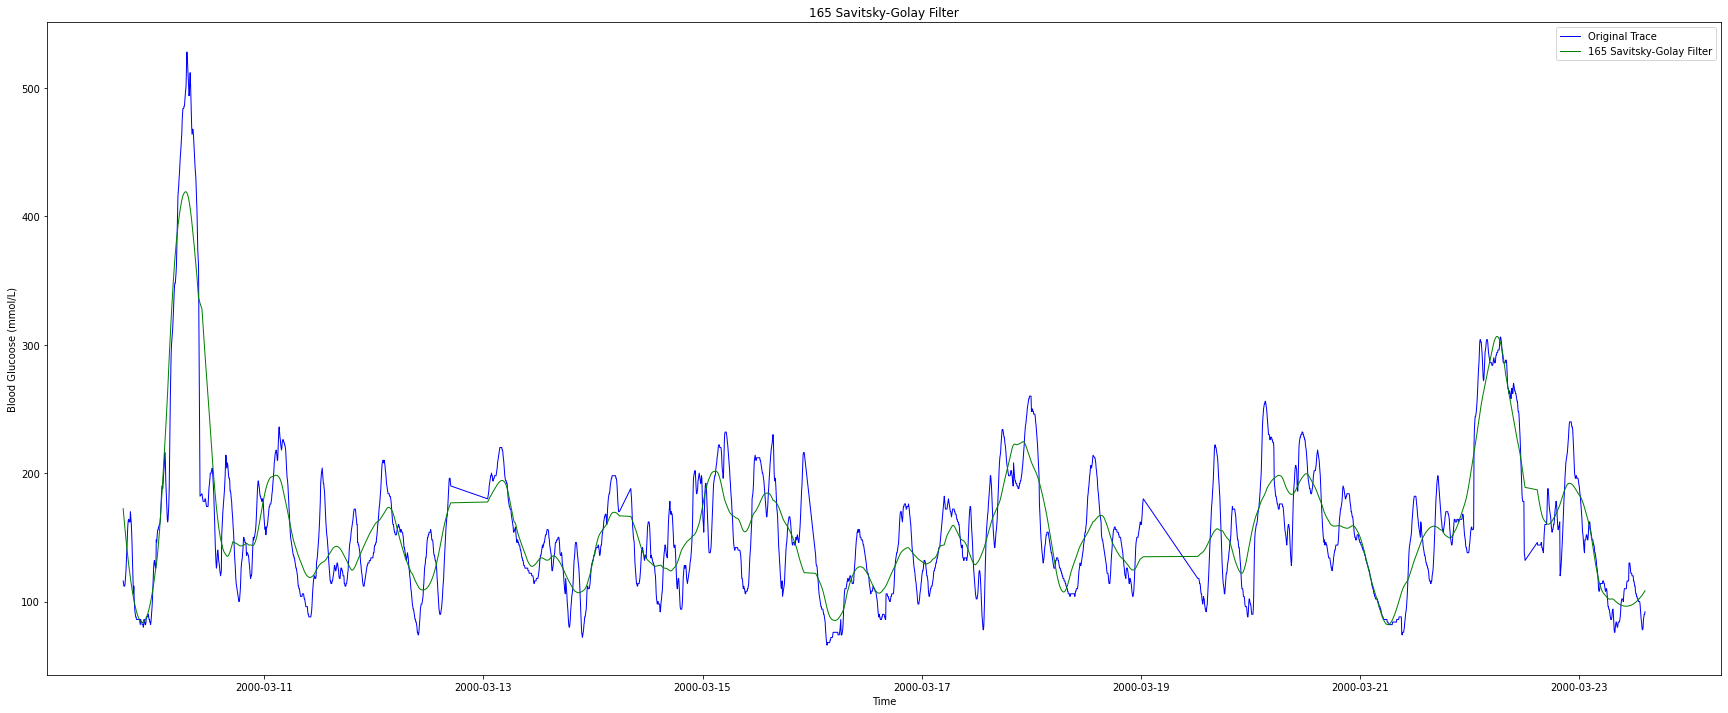

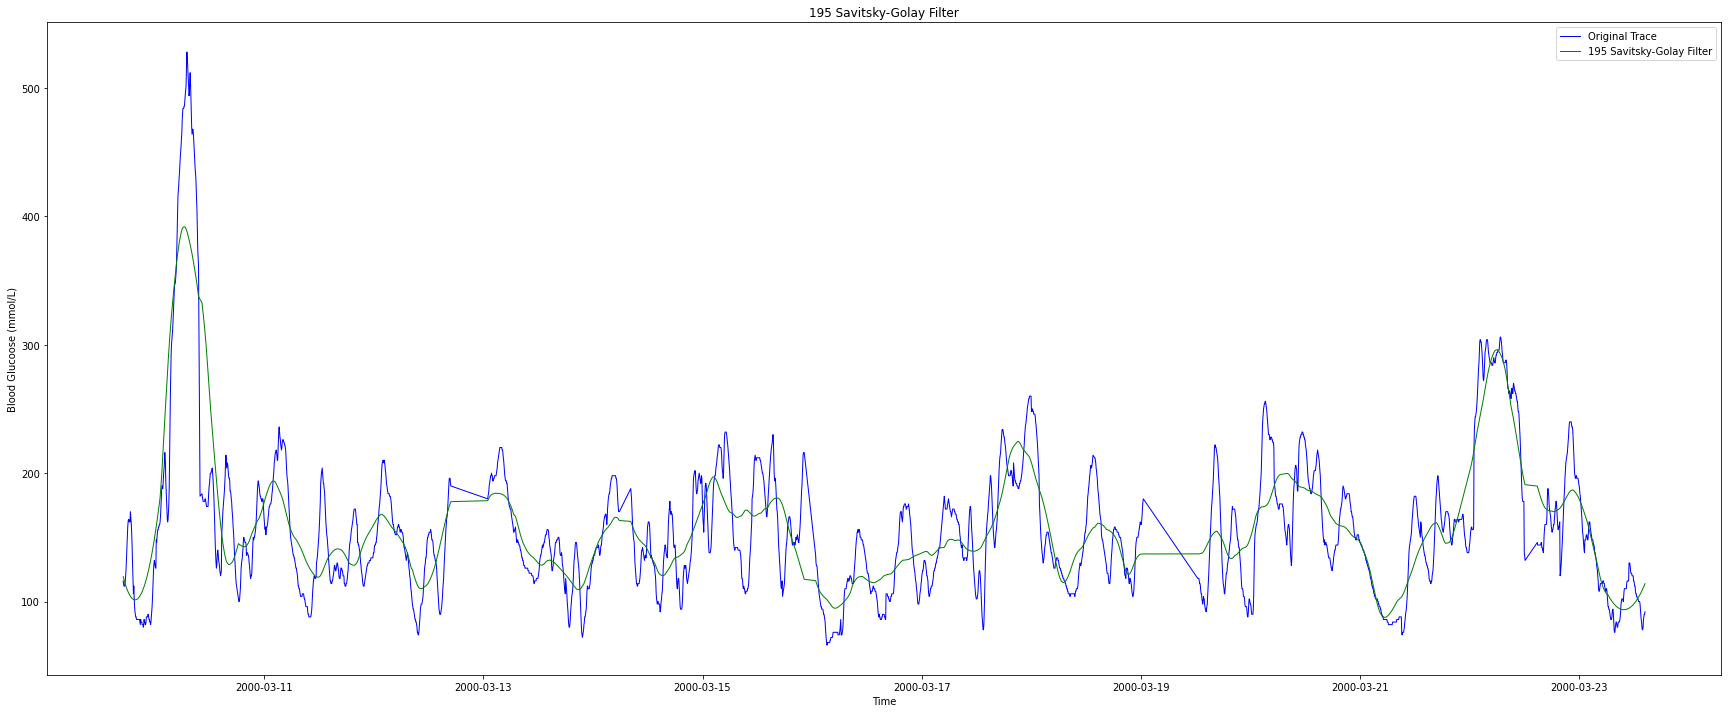

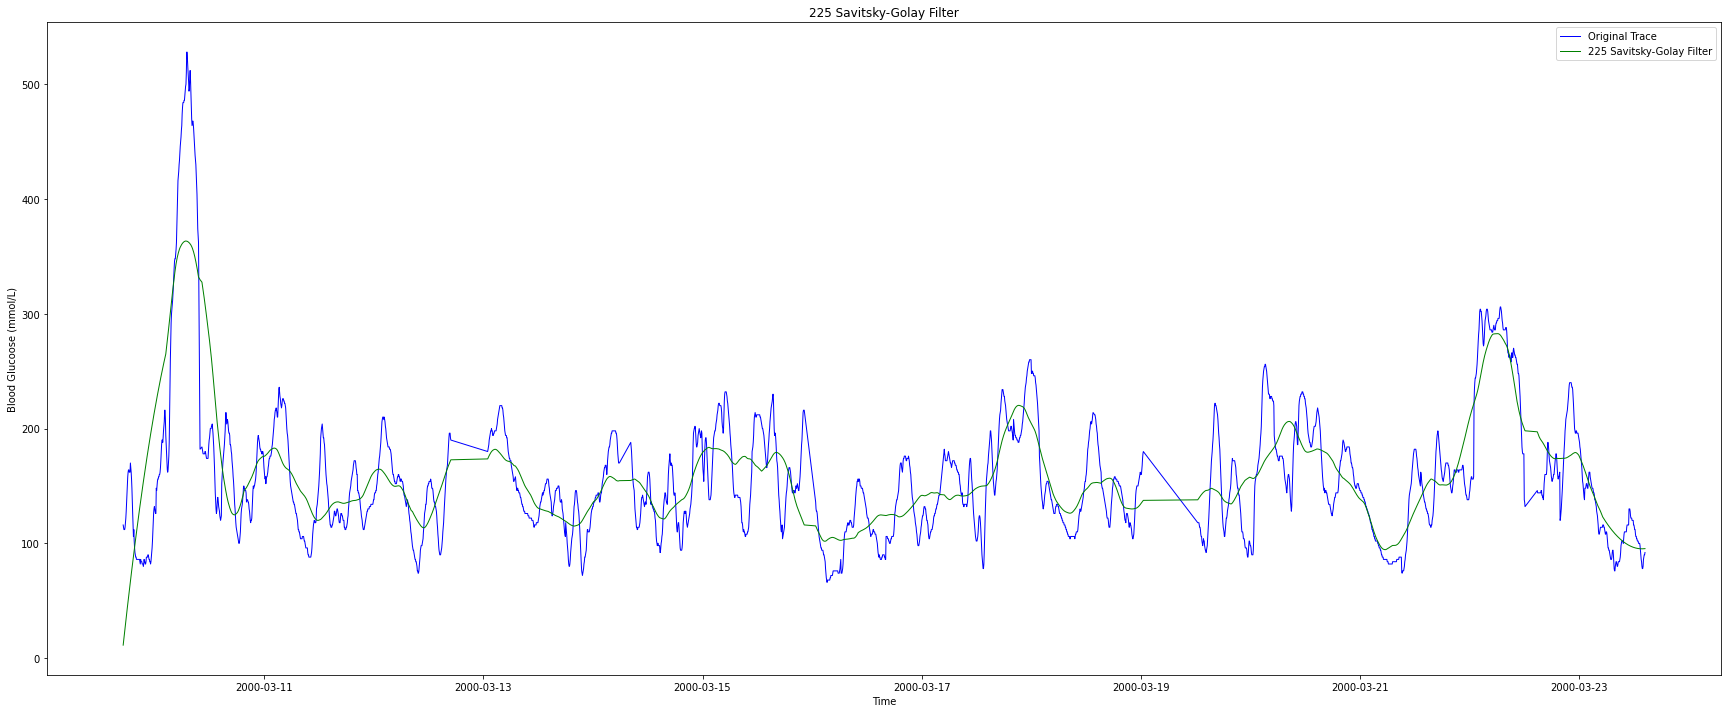

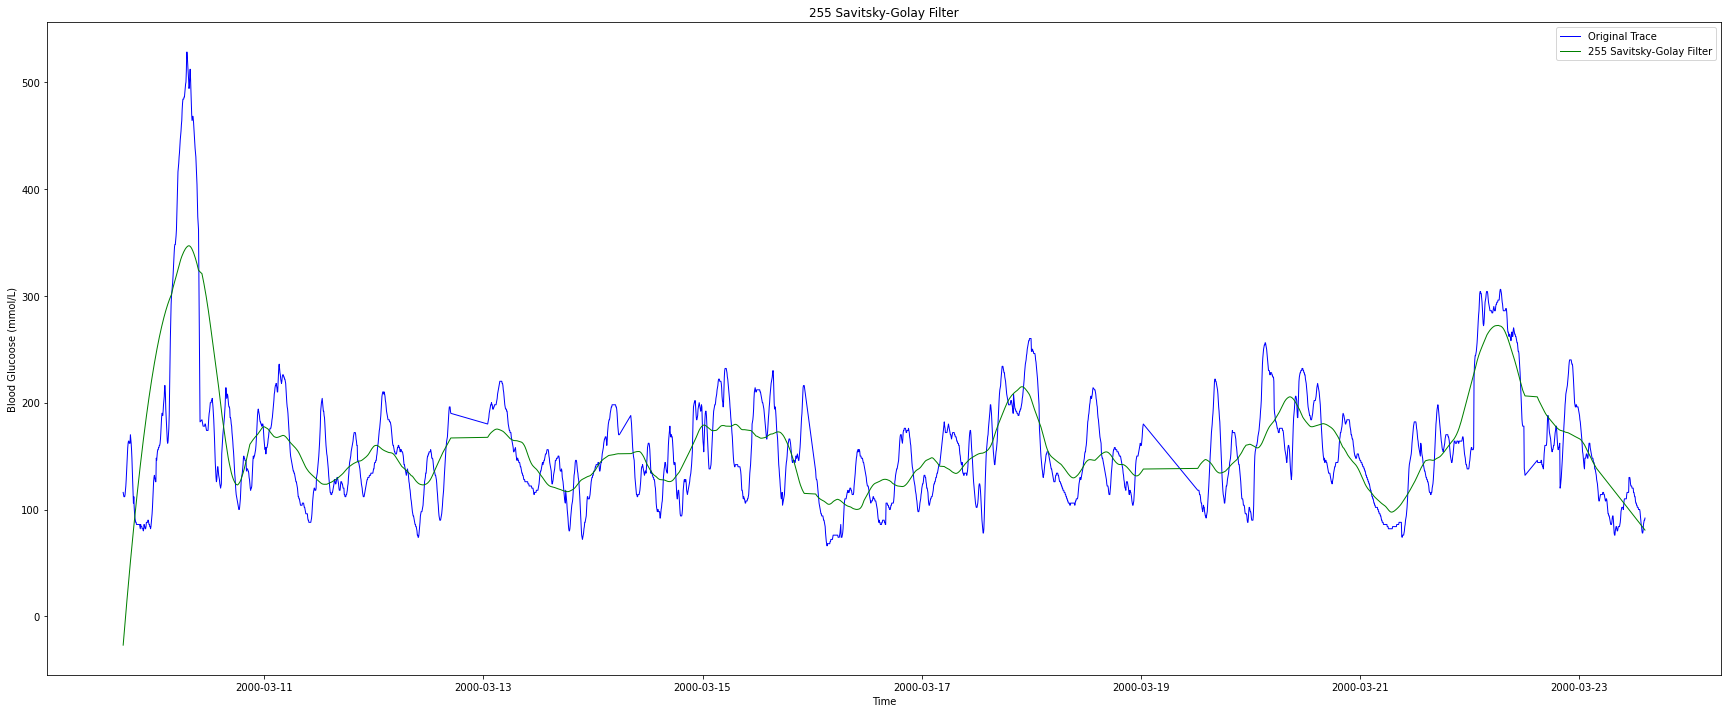

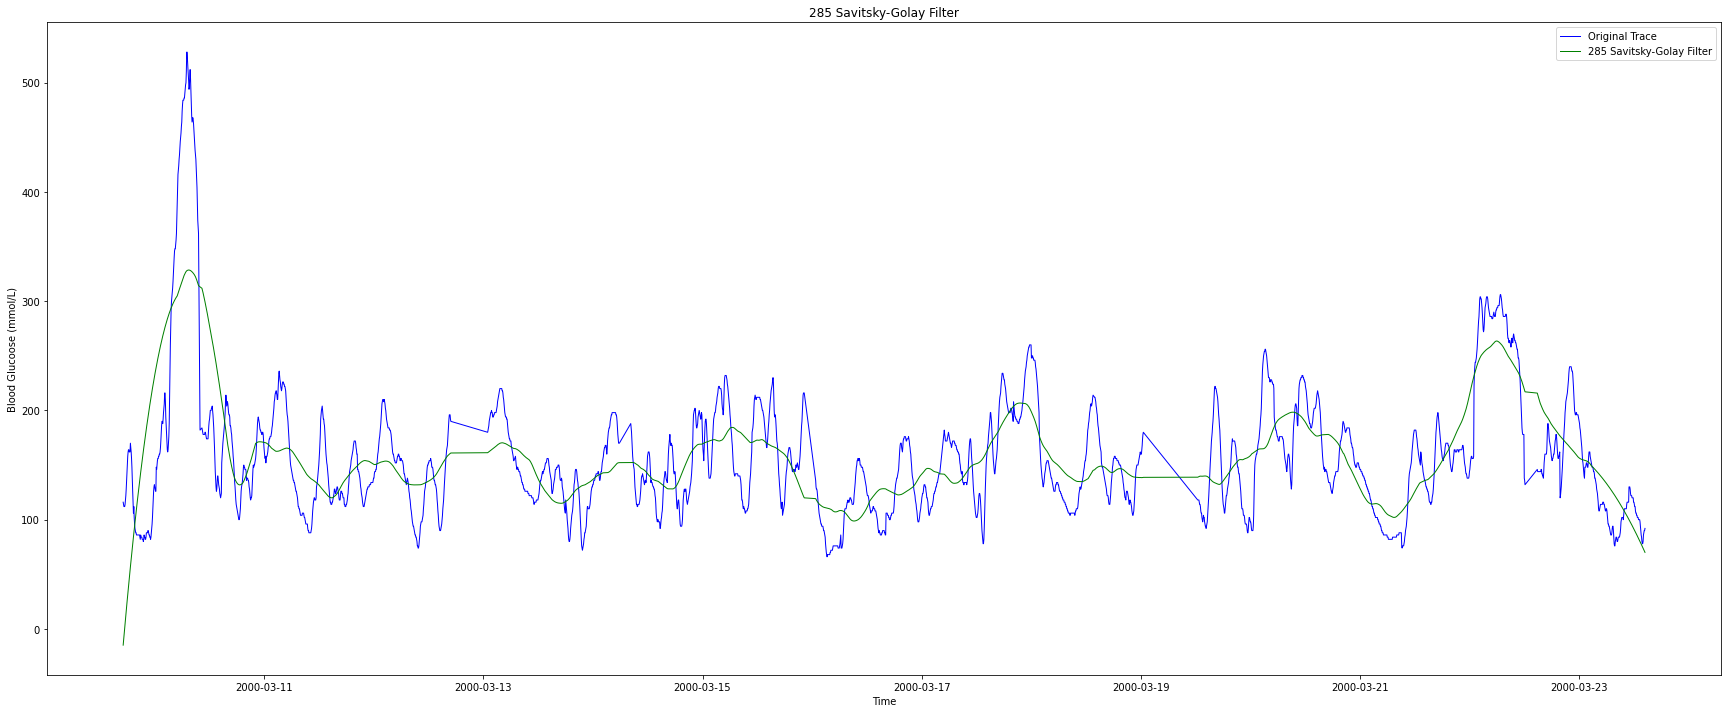

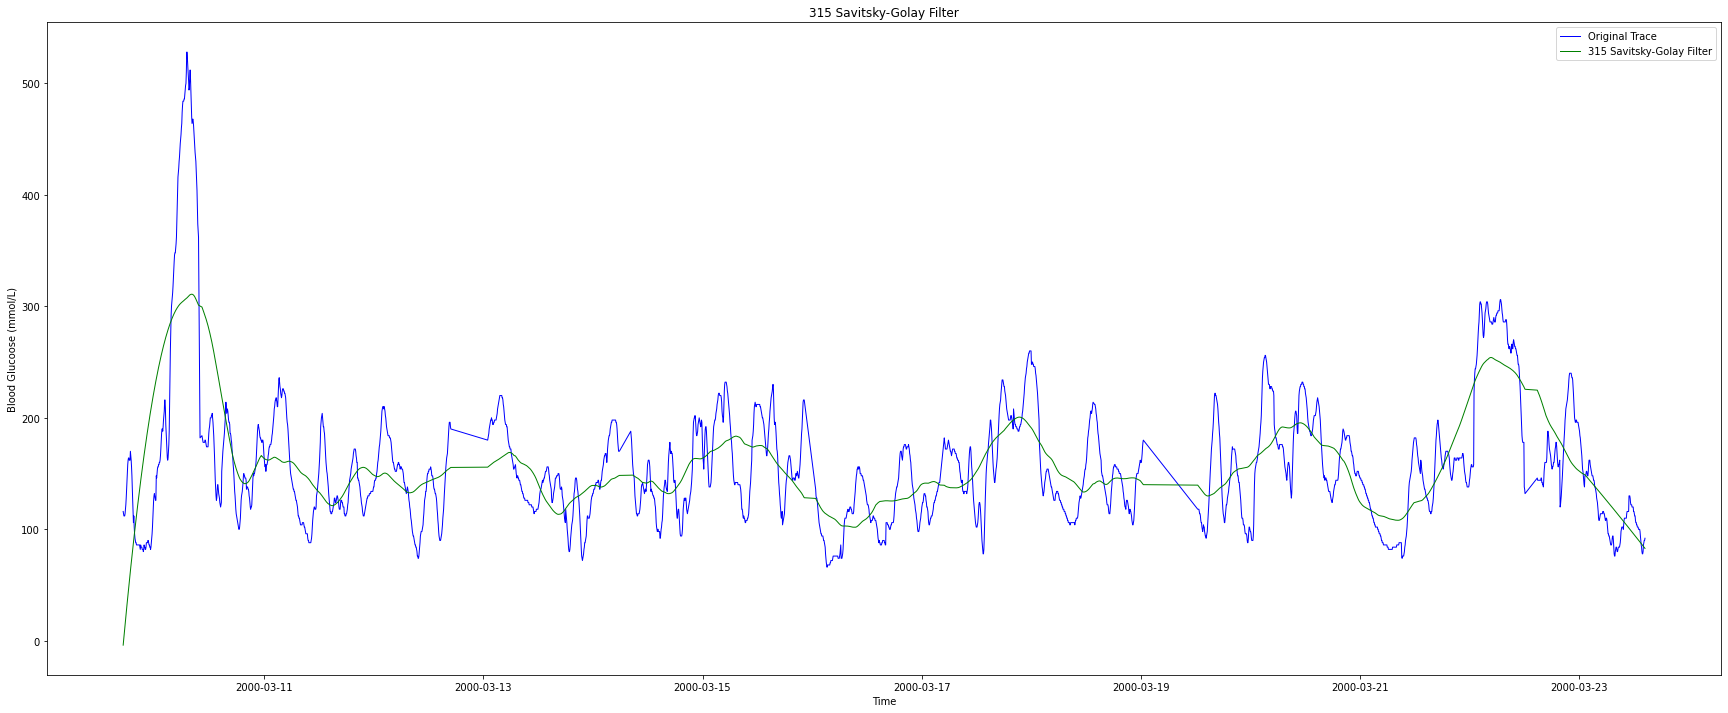

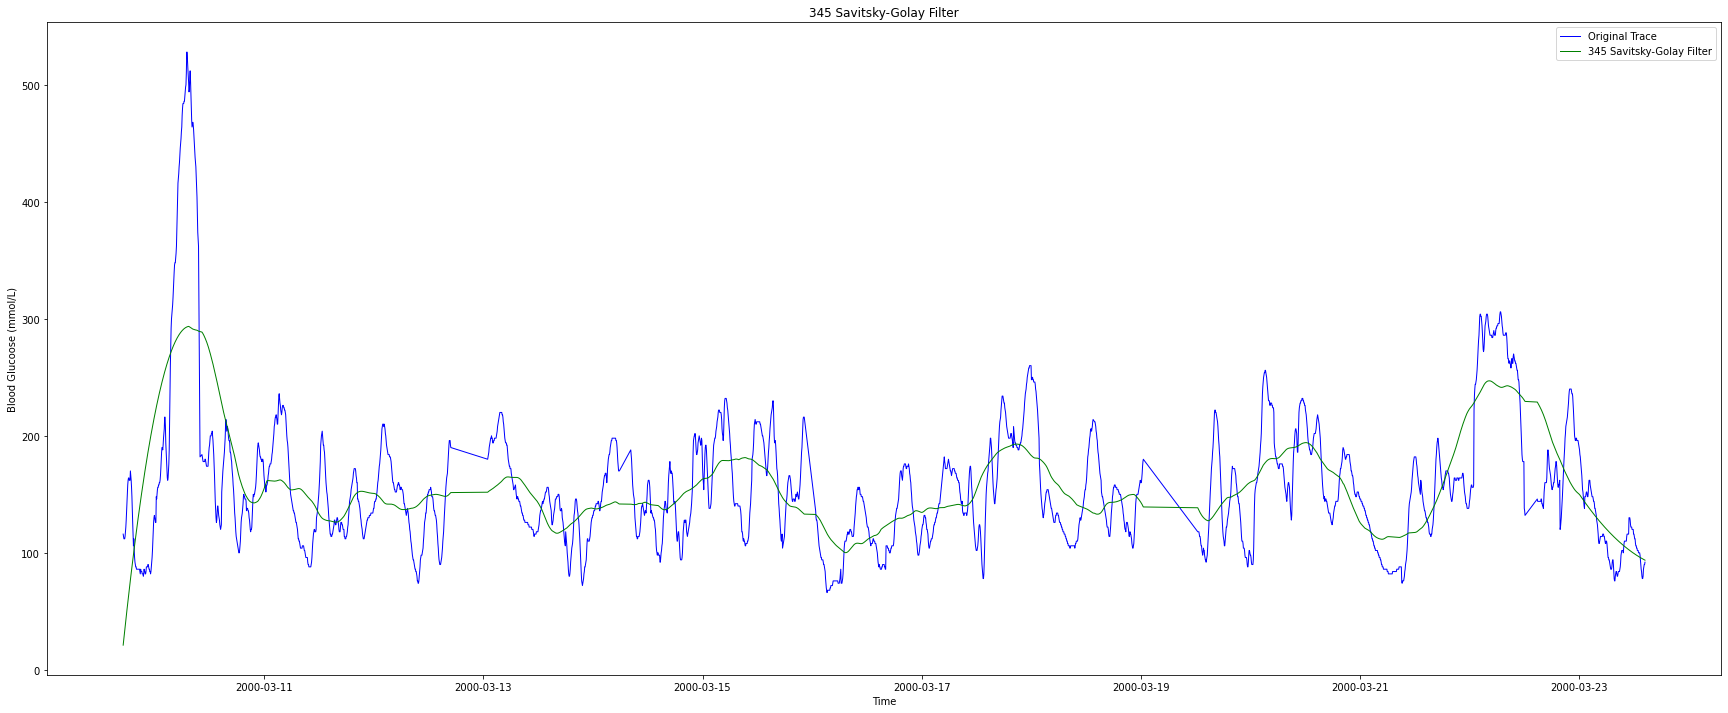

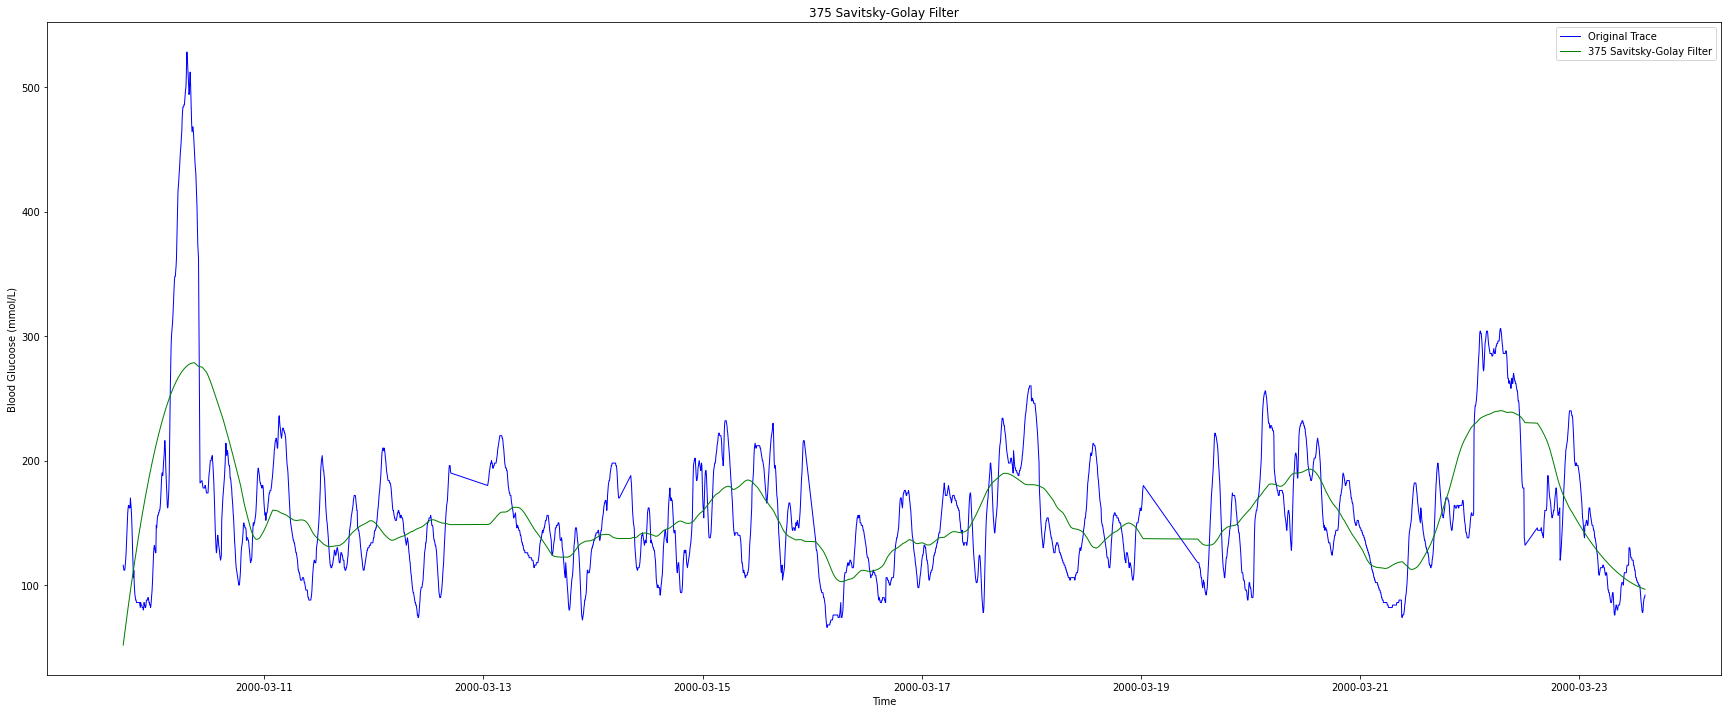

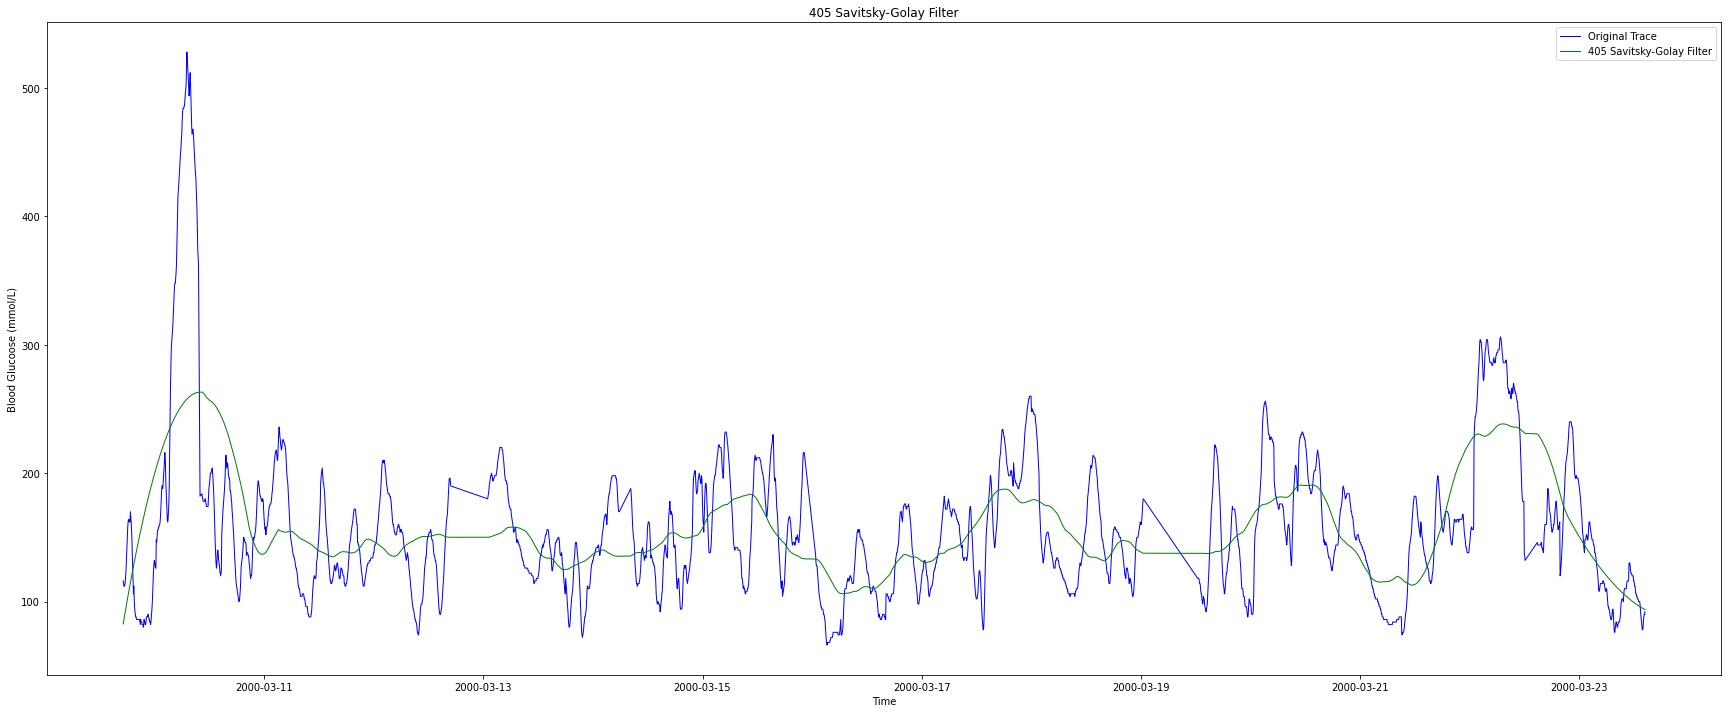

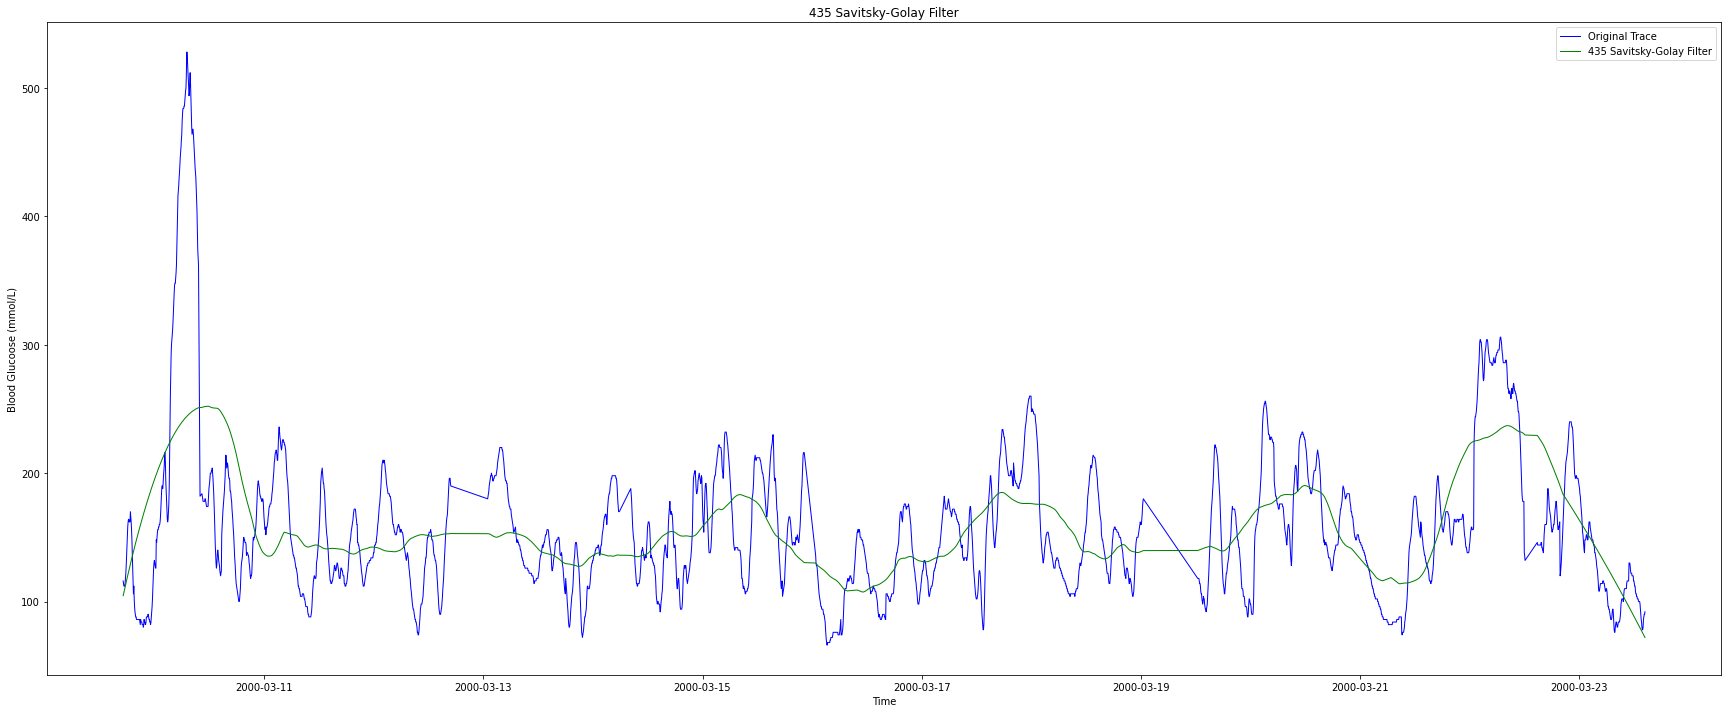

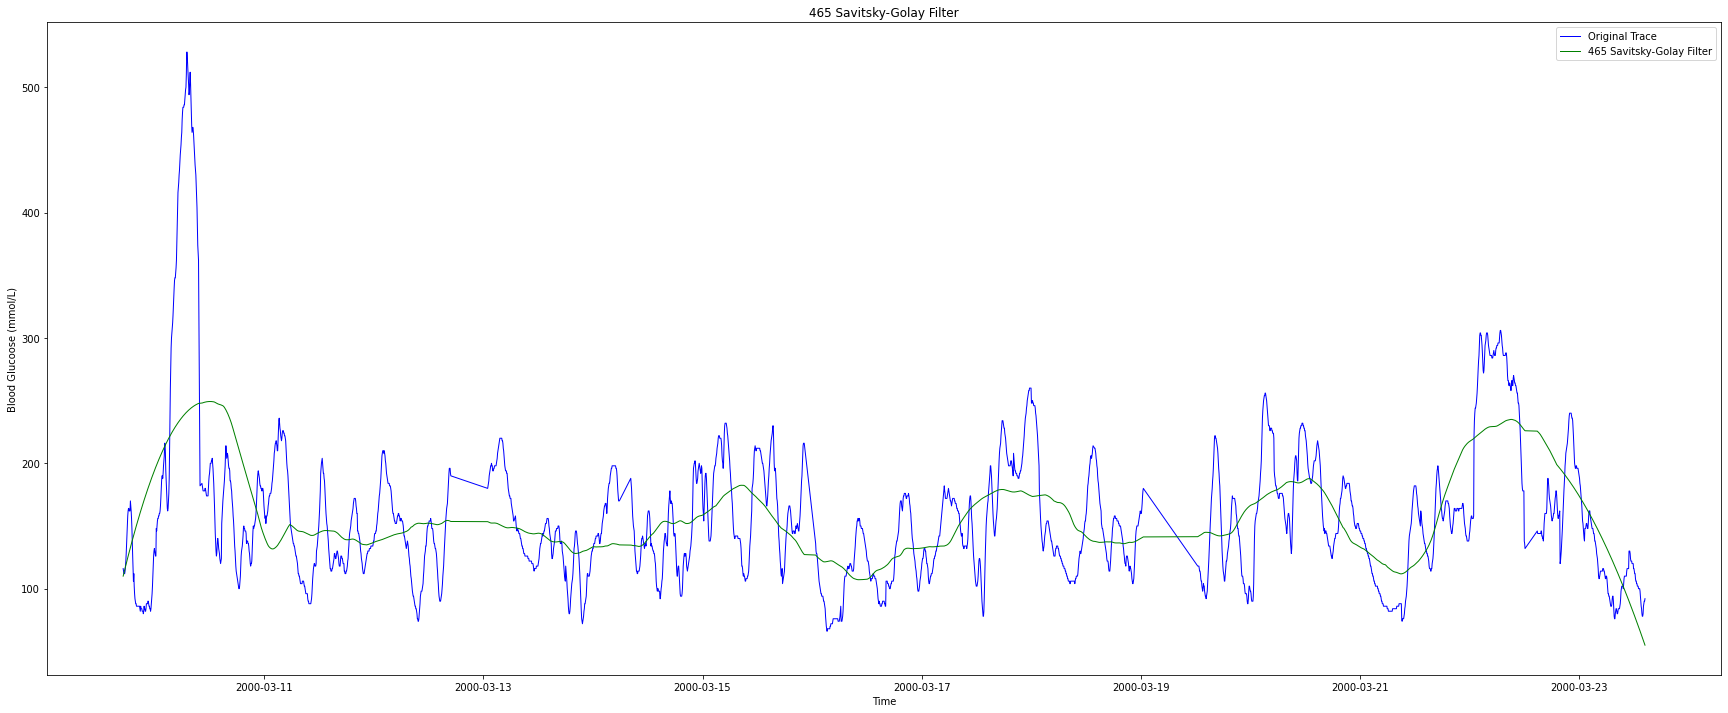

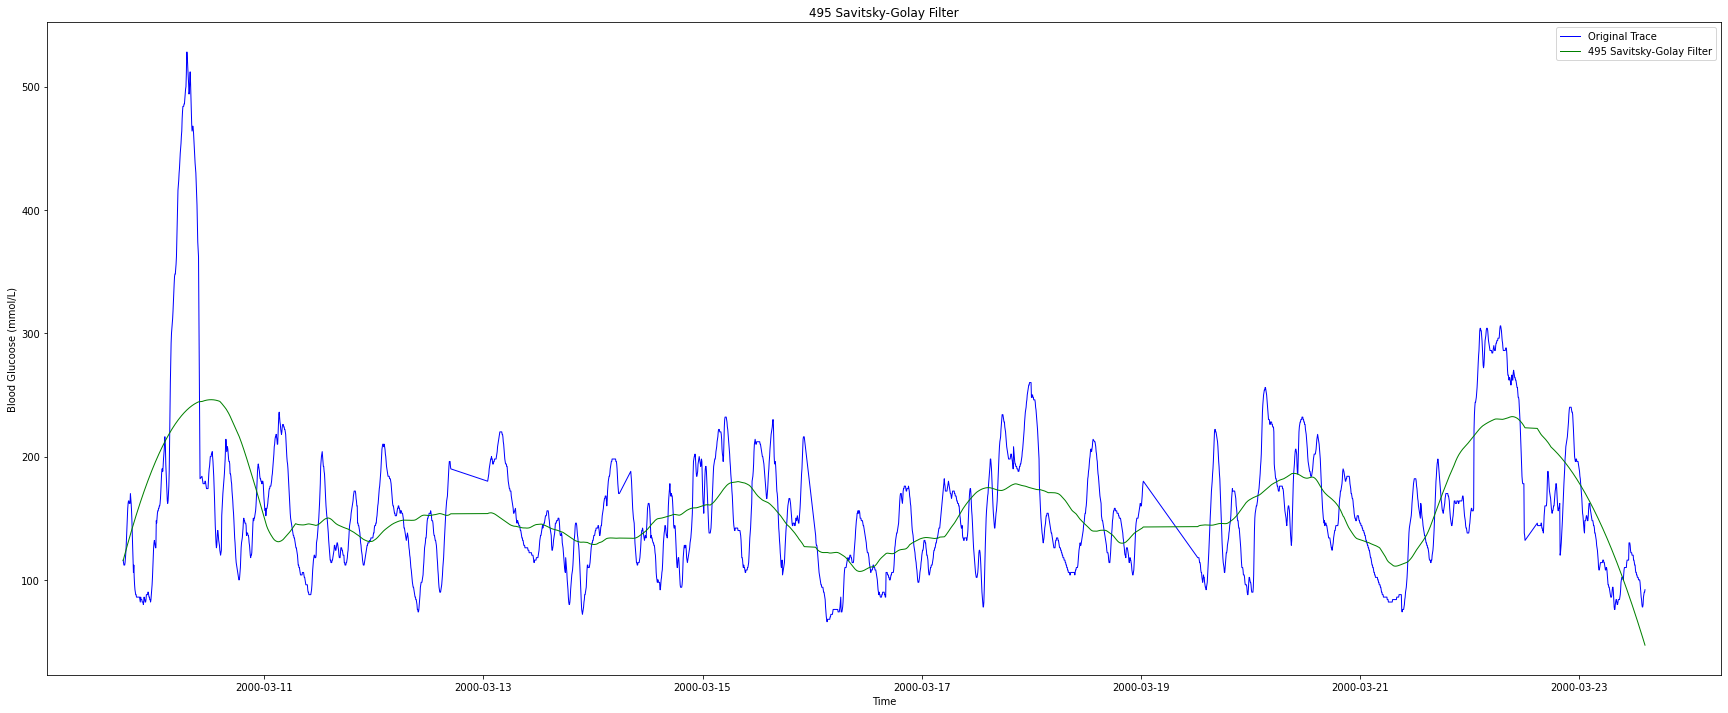

In [6]:
# Iterate through different graphic comparisons of filters
for n in range(15, 501, 30):

  # Create graphics
  df_321 = pts[321]
  fig, ax = plt.subplots(figsize=(30, 12))
  ax.set_title(f'{n} Savitsky-Golay Filter')
  ax.set_xlabel('Time')
  ax.set_ylabel('Blood Glucoose (mmol/L)')

  # Display the actual trace
  ax.plot(pts[321]['time'], pts[321]['glucose_lvl'], LineWidth=1,
          label='Original Trace', color='Blue')

  # Apply Savitsky-Golay filter
  blood_gluc = df_321['glucose_lvl'].to_list()
  filtered = savgol_filter(blood_gluc, n, 2)
  ax.plot(df_321['time'].to_list(), filtered, LineWidth=1,
          label=f'{n} Savitsky-Golay Filter', color='Green')
  ax.legend()
  plt.show()

In [7]:
# Chosen Savitski-Golay filter: 51 window, poly 2

# Create patients dictionary
pts_f = dict()

# Filter all day
for ptID in pts.keys():

  # Copy the data
  unfiltered_data = pts[ptID]

  # Filter
  blood_gluc = unfiltered_data['glucose_lvl'].to_list()
  filtered = savgol_filter(blood_gluc, 51, 2)

  # Reform data
  filtered_data = pts[ptID].copy()
  filtered_data = filtered_data.rename(columns={'glucose_lvl': 'glucose_lvl_unf'})
  filtered_data['glucose_lvl_f'] = filtered

  # Arrange data
  filtered_data = filtered_data.sort_values('time')

  # Add to dictionary
  pts_f[ptID] = filtered_data

### **Part 3:** Pass Moving Filter to Find Substantial Peaks

In [8]:
# Get peaks and associated valeys of substantially large blood glucose peaks
def getPeaksAndValleys(pts, min_height, dist, dt_max):
  
  # make copy of pts
  pts_copy = pts.copy()


  # Iterate through eat pts
  for pt in pts.keys():
  
    # PEAKS

    # Find peak values for this patient
    this_pt = pts[pt]
    bg = this_pt['glucose_lvl_f'].to_list()
    time = this_pt['time'].to_list()
    peak_inds = find_peaks(bg, height=min_height, distance=dist)[0]
    peak_times = list(map(lambda i : time[i], peak_inds))

    # Form list of peaks
    is_peak = list(map(lambda x : x in peak_inds, range(len(bg))))
    
    # Add peaks to patient DataFrames
    pts_copy[pt]['is_peak'] = is_peak

    # VALLEYS

    # Get time range
    peak_range_highs = this_pt[this_pt['is_peak'] == True]['time'].to_list()
    peak_range_lows = list(map(lambda x : x - timedelta(hours=dt_max), peak_range_highs))
    times_all = this_pt['time'].to_list()

    # Get min value in these ranges
    valley_times = []
    for i in range(len(peak_range_highs)):

      # Get range of time for this interval
      high = peak_range_highs[i]
      low = peak_range_lows[i]
      time_range_int = this_pt[this_pt['time'] <= high]
      time_range = time_range_int[time_range_int['time'] >= low]
      blood_glucs = time_range['glucose_lvl_f'].to_list()
      times = time_range['time'].to_list()

      # Get minimum value
      min = 100000
      time = None
      for j in range(len(blood_glucs)):
        if (blood_glucs[j] < min):
          min = blood_glucs[j]
          k = j
          time = times[j]
      
      # Append estimated valley time
      valley_times.append(time)

    # Create column of valley times
    is_valley = list(map(lambda x : x in valley_times, times_all))
    pts_copy[pt]['is_valley'] = is_valley

    # INCLINEs
    
    # Get incline ranges
    prob_times = this_pt['time'].to_list()
    is_incline = [False for i in range(len(prob_times))]
    for i in range(len(peak_inds)):

      # Get start and stop times
      start = valley_times[i]
      end = peak_times[i]

      # Replace all values in the range with True
      for j in range(len(is_incline)):
        if (prob_times[j] <= end and prob_times[j] >= start):
          is_incline[j] = True

    # Create column of incline times
    pts_copy[pt]['is_incline'] = is_incline

  # Return back dictionary
  return pts_copy

# Get graph showing peaks and valleys
def displayPeaksAndValleys(pts, i, show_incline=False):
  fig, ax = plt.subplots(figsize=(30, 12))
  ax.plot(pts[i]['time'], pts[i]['glucose_lvl_f'], color='green')
  ax.scatter(pts[i][pts[i]['is_peak'] == True]['time'],
             pts[i][pts[i]['is_peak'] == True]['glucose_lvl_f'],
             color='red', label='Blood Glucose Peak')
  ax.scatter(pts[i][pts[i]['is_valley'] == True]['time'],
             pts[i][pts[i]['is_valley'] == True]['glucose_lvl_f'],
             color='blue', label='Blood Glucose Valley')
  if (show_incline):
      ax.scatter(pts[i][pts[i]['is_incline'] == True]['time'],
             pts[i][pts[i]['is_incline'] == True]['glucose_lvl_f'],
             color='purple', label='Blood Glucose Incline Range')
  ax.set_title(f'Blood Glucose Trace for Patient {i}')
  ax.set_xlabel('Date')
  ax.set_ylabel('Filtered Blood Glucose (mmol/L)')
  ax.legend()
  plt.show()

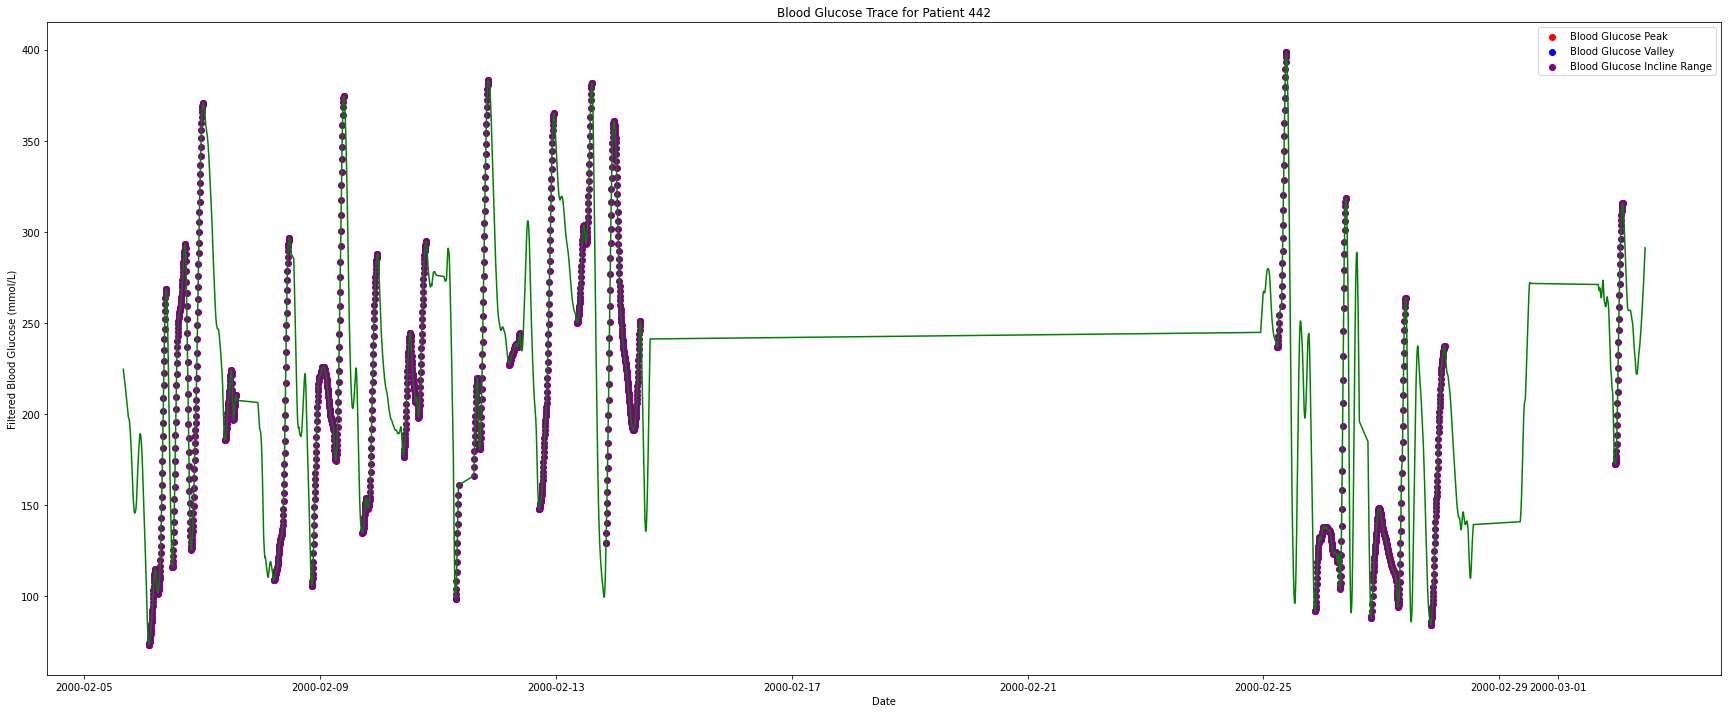

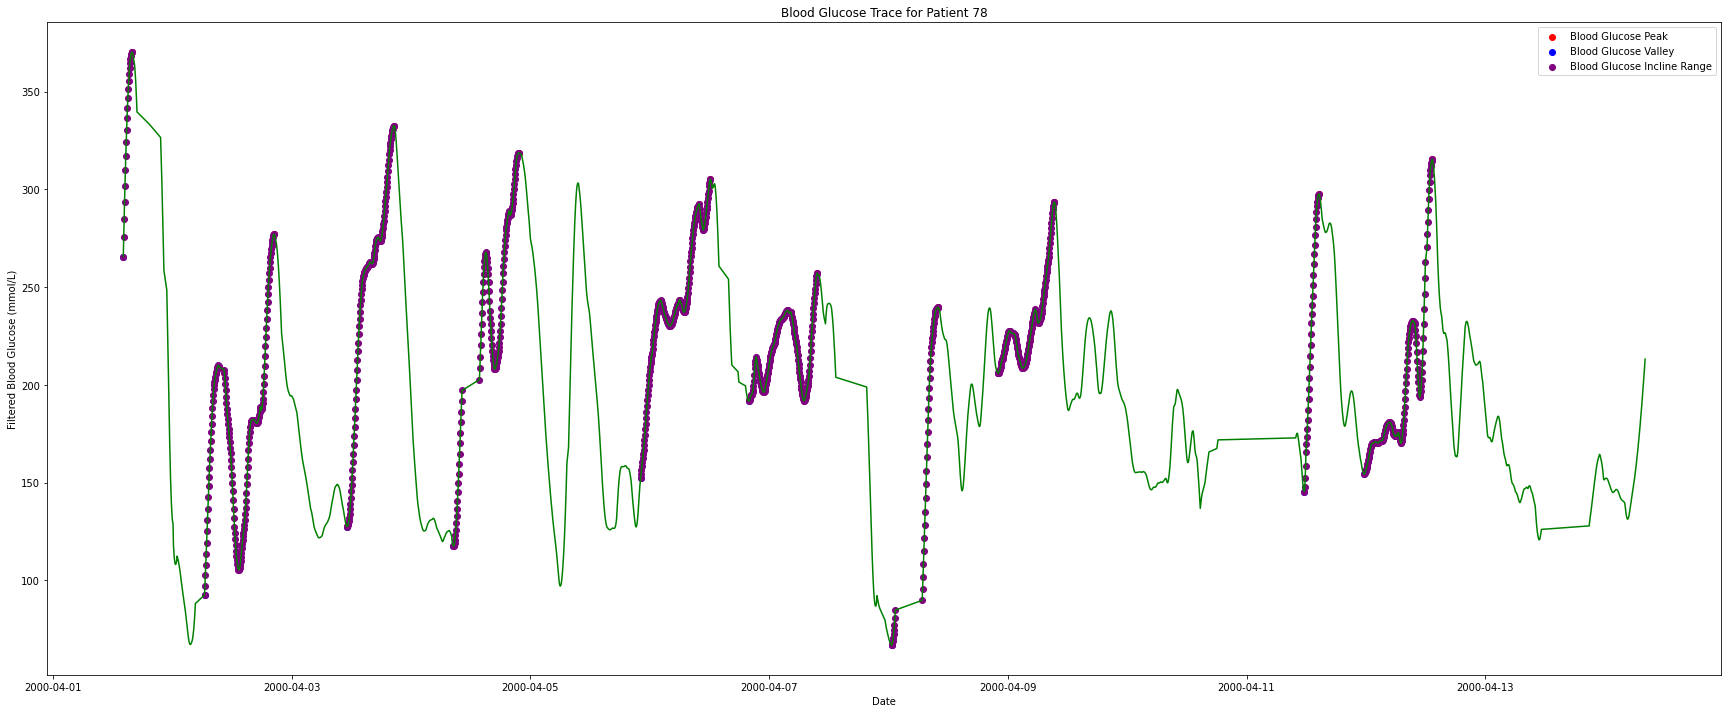

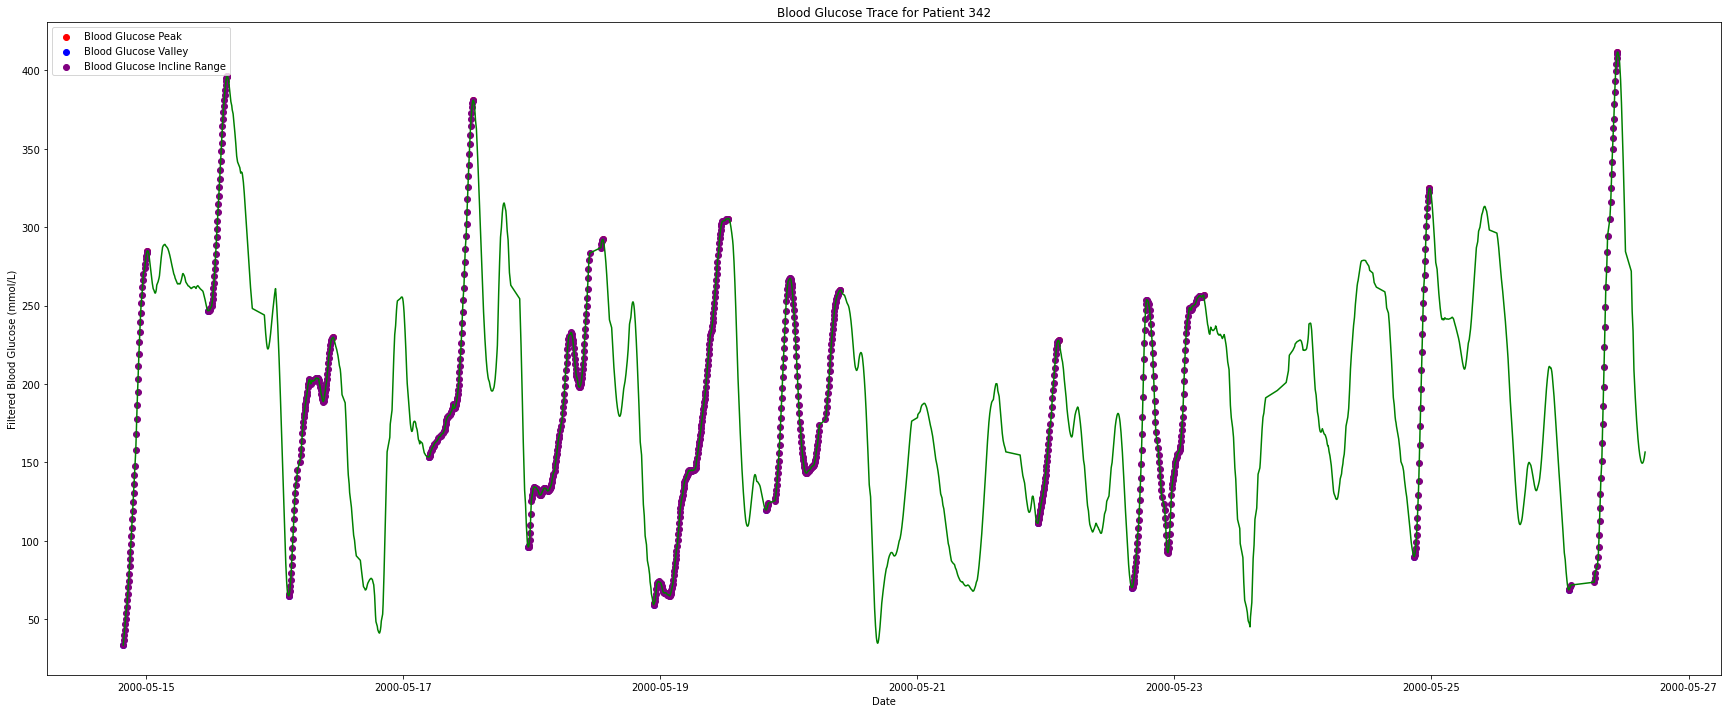

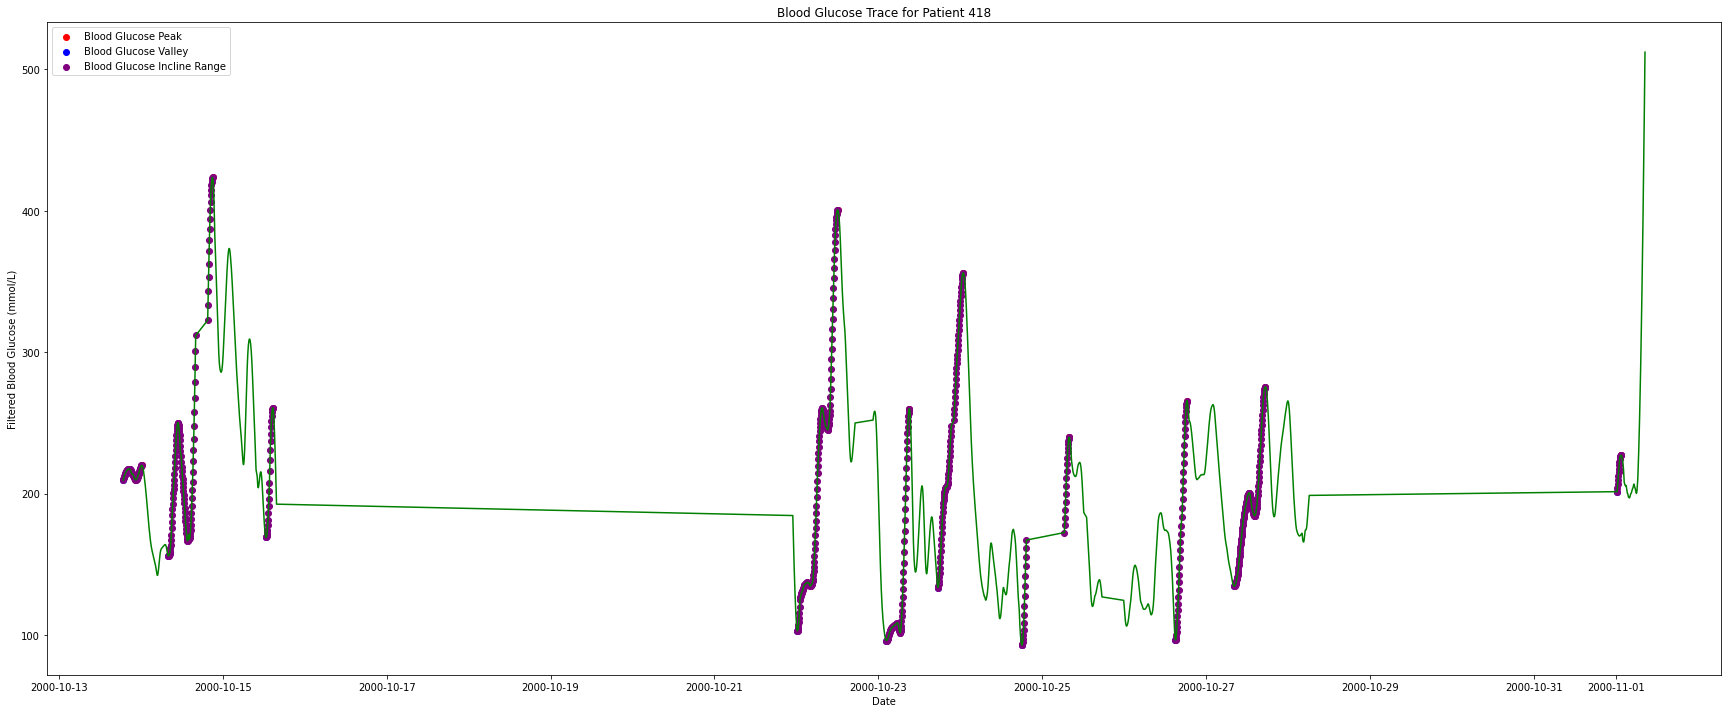

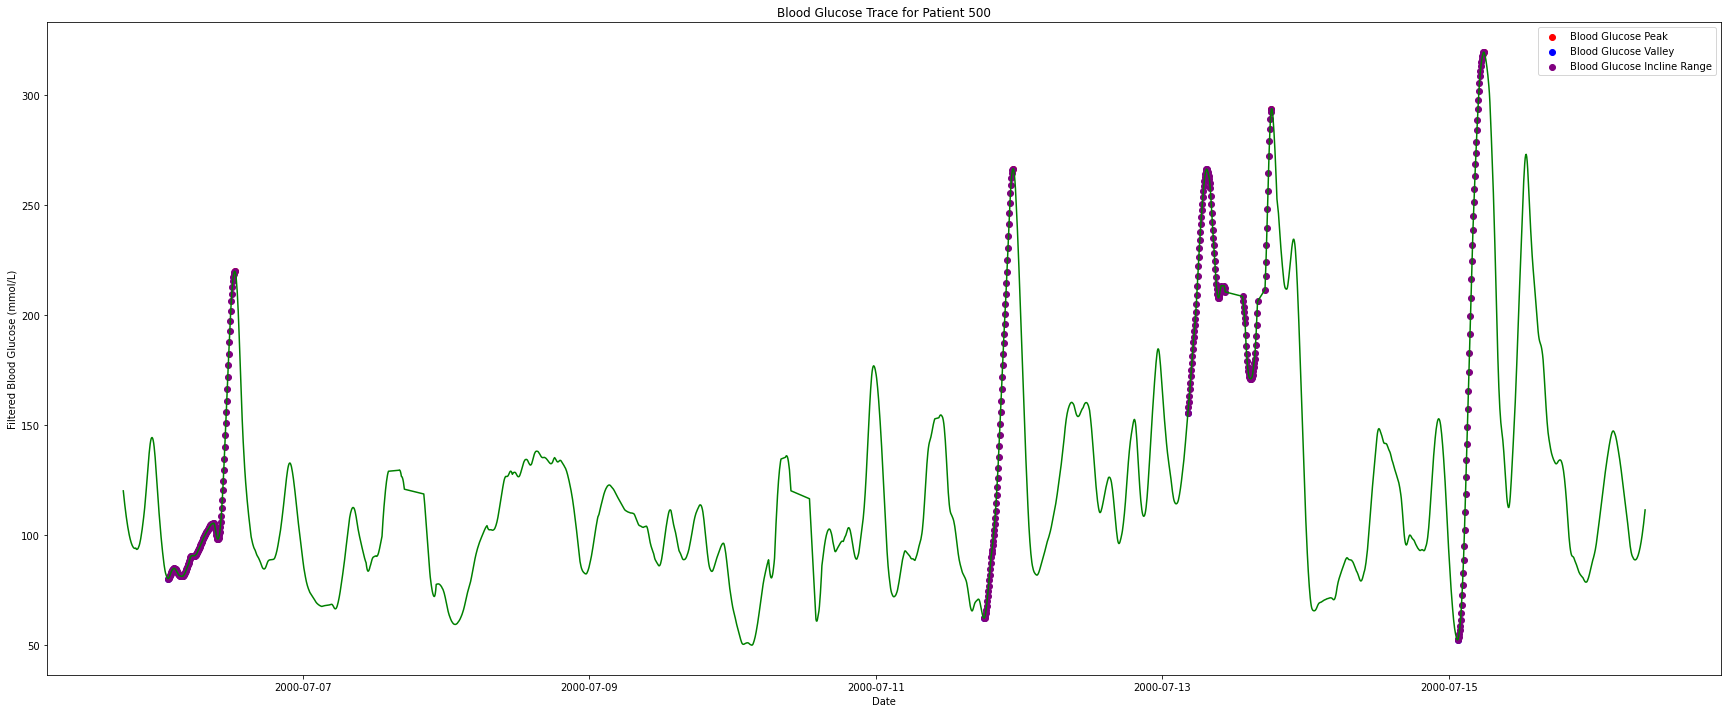

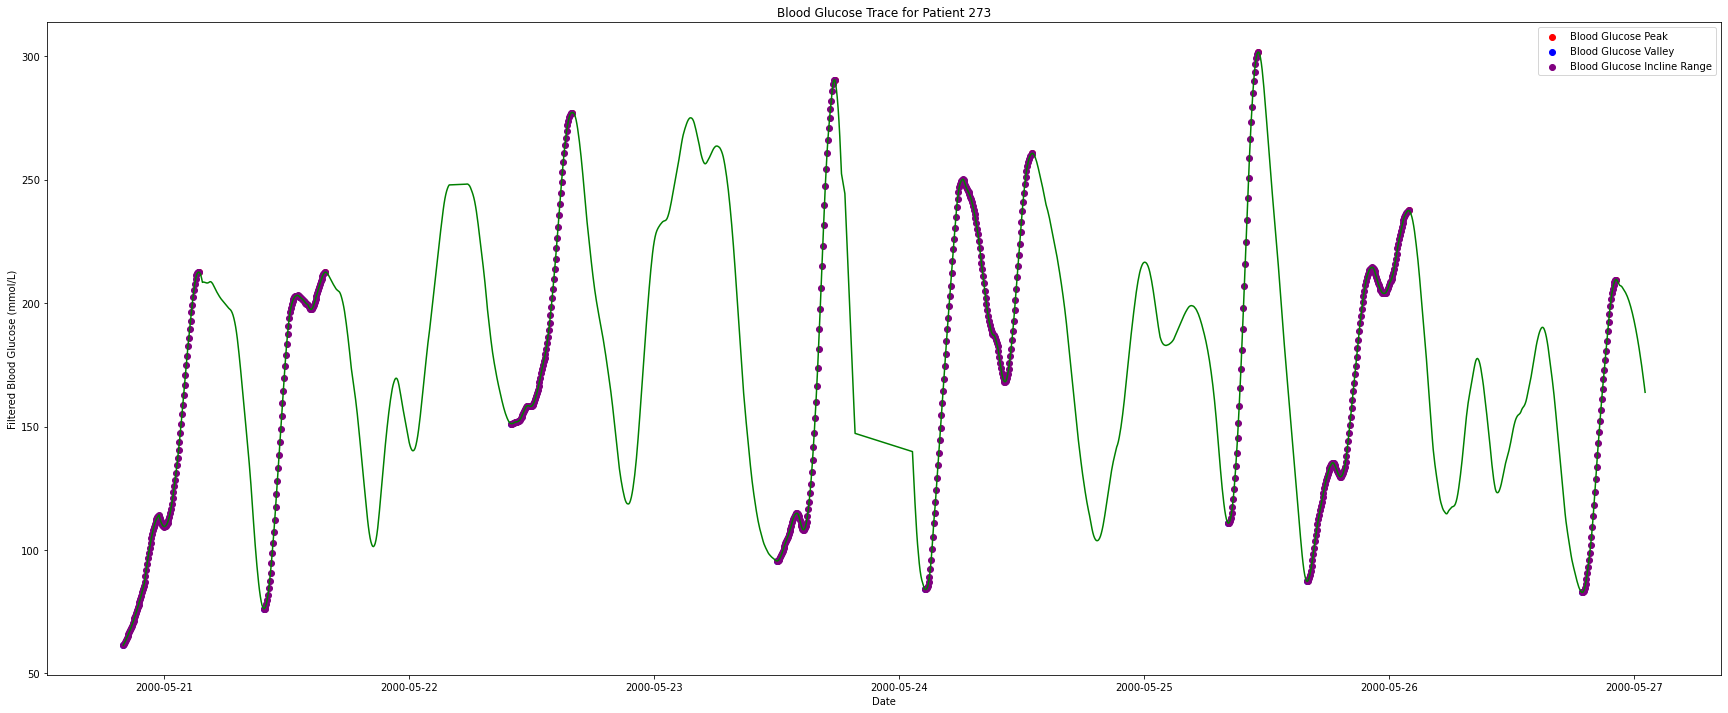

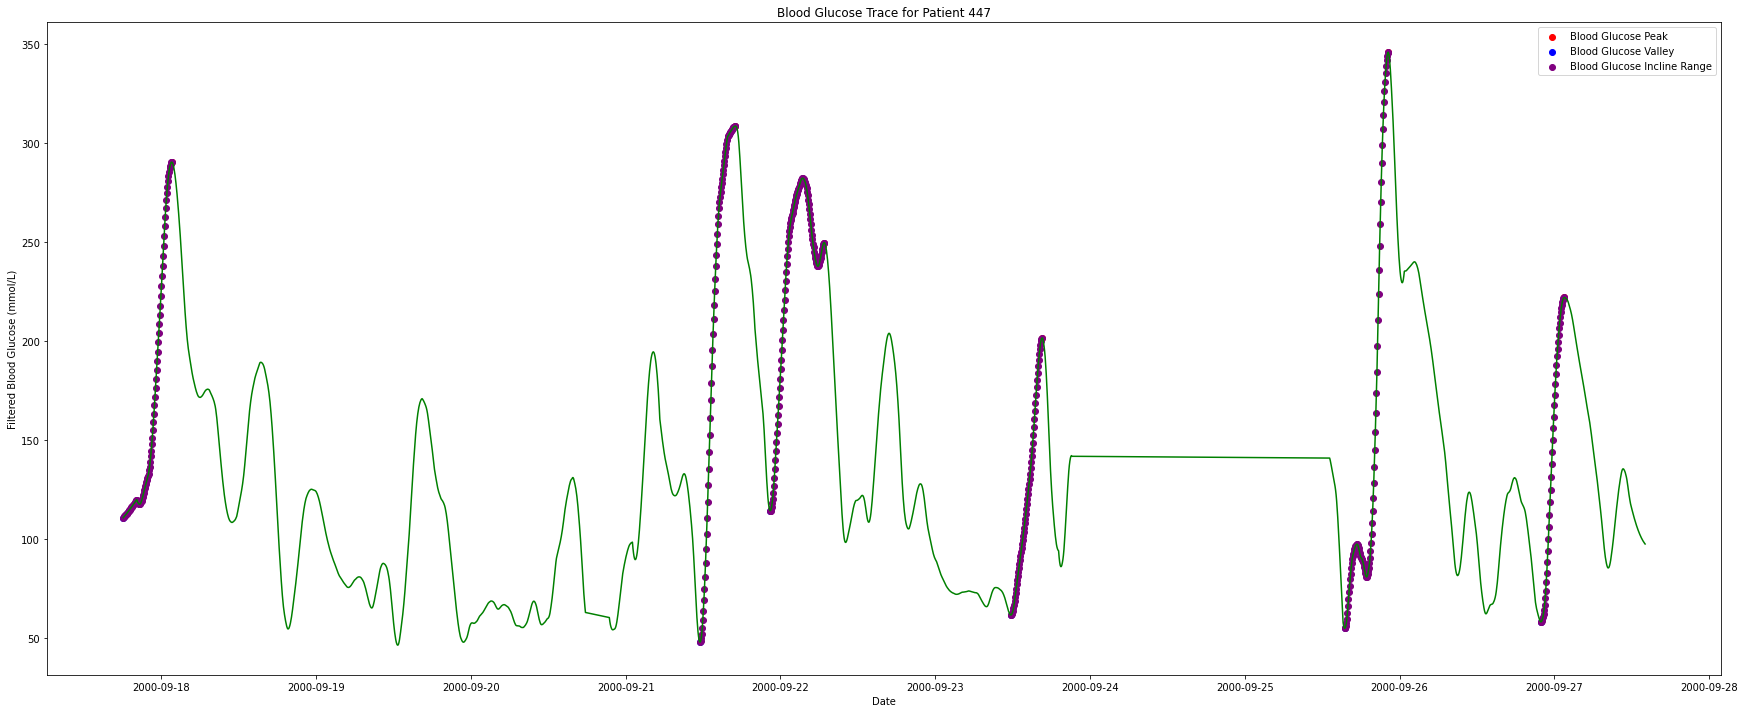

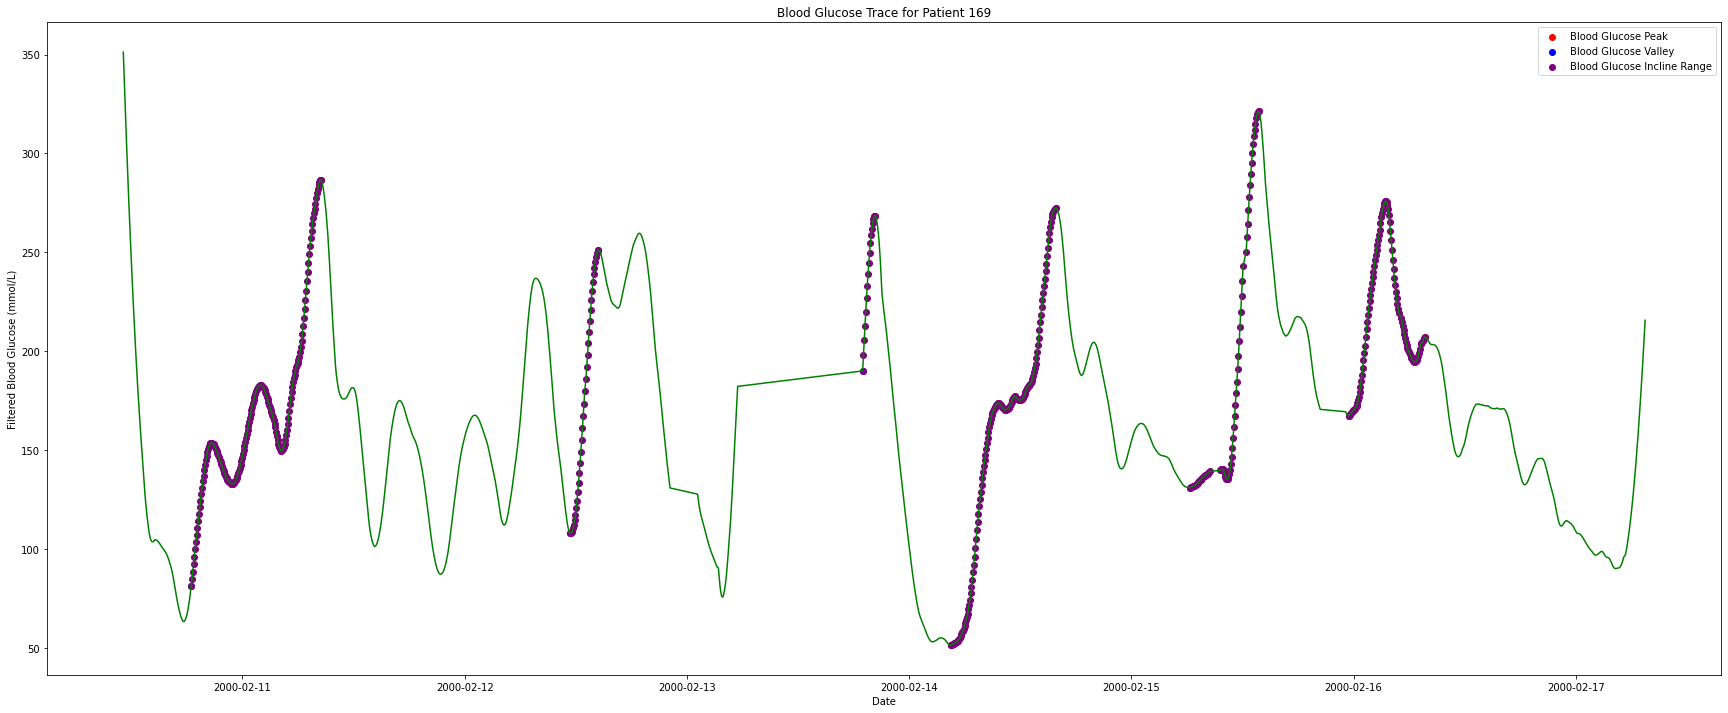

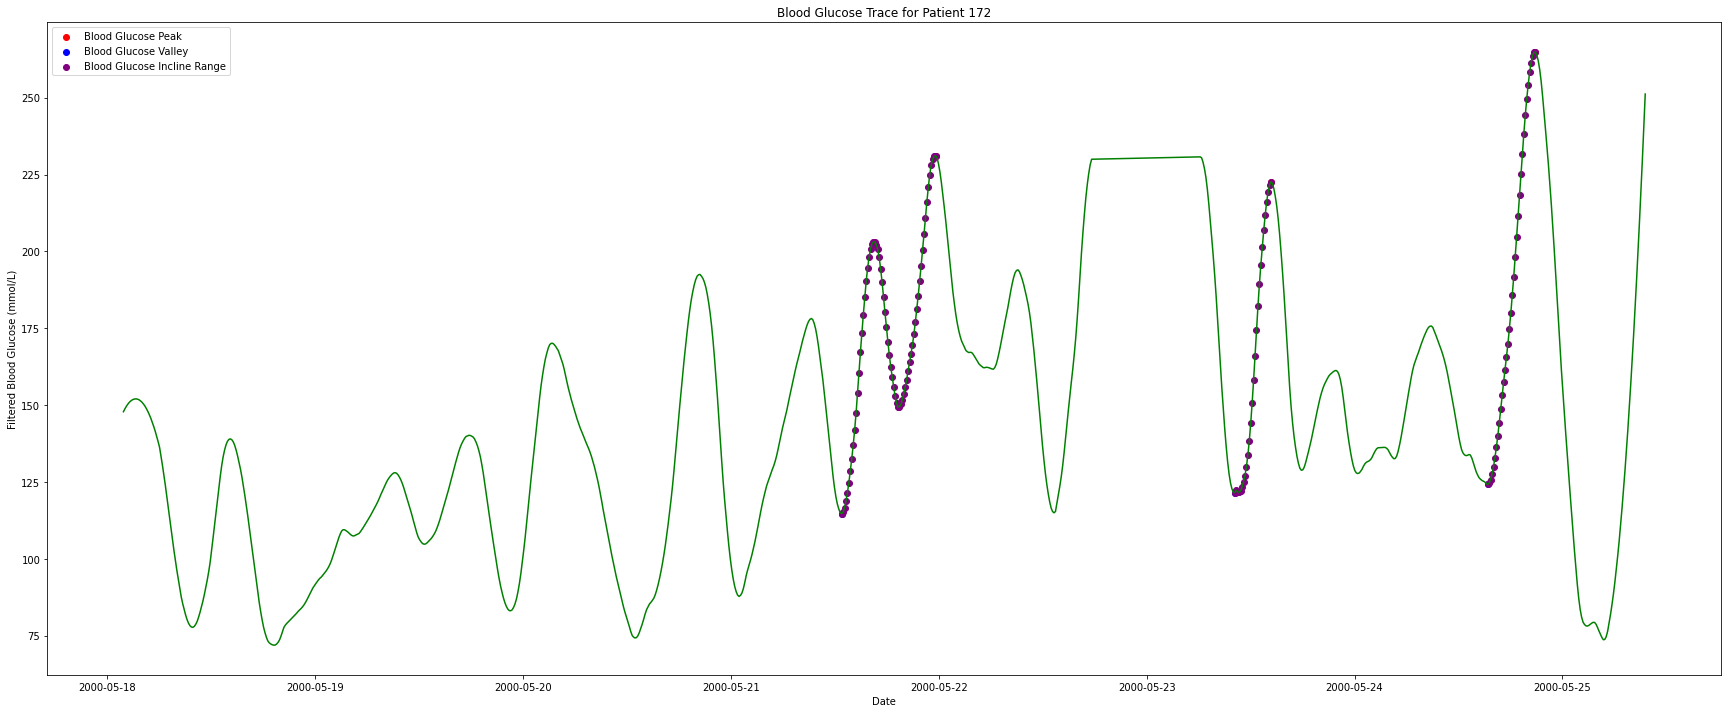

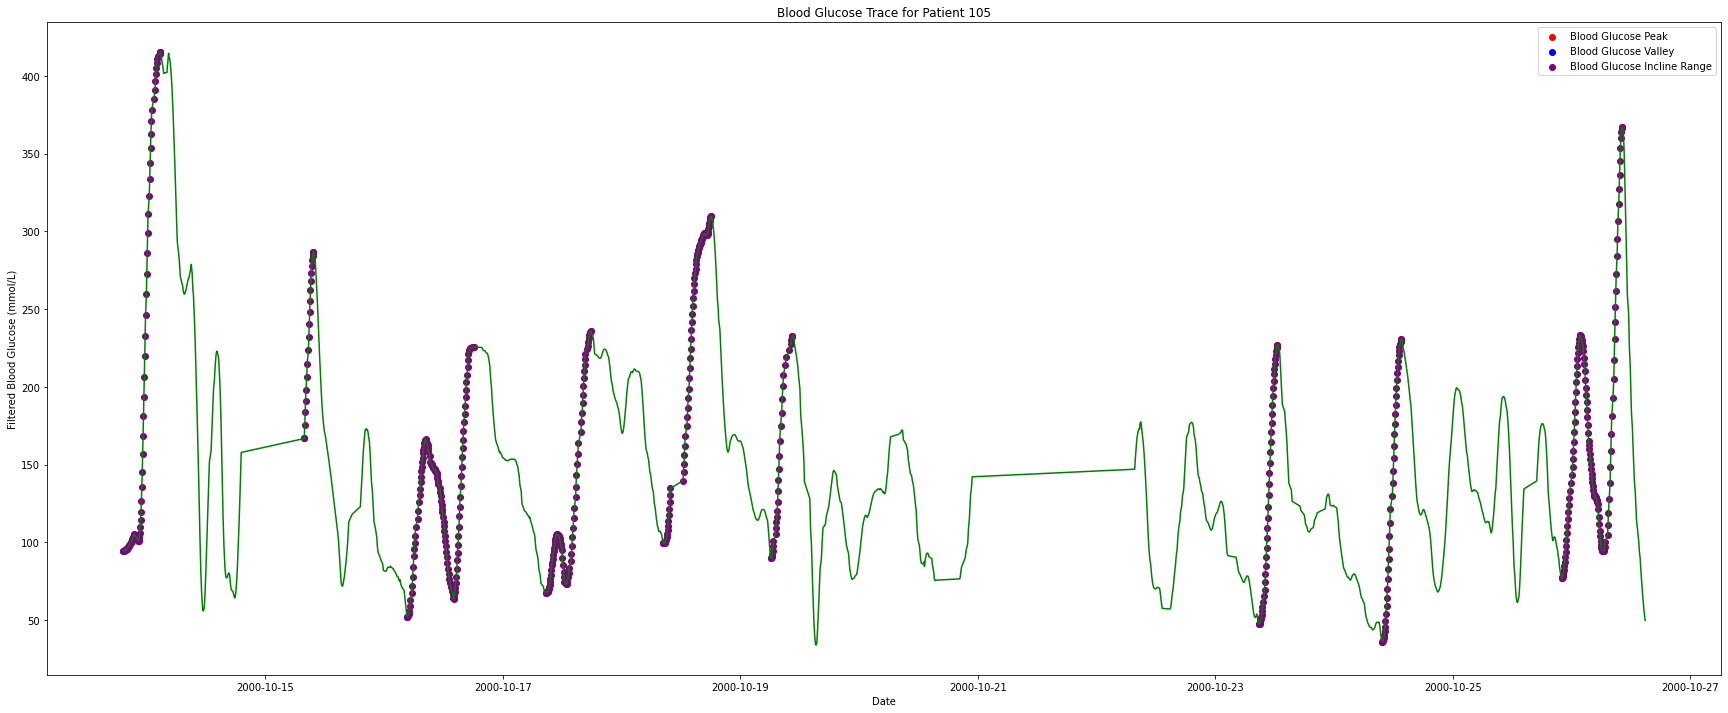

In [10]:
# Get peaks and valleys
pts_clean = getPeaksAndValleys(pts_f, 200, 144, 14)

# Display all traces
for pt in list(pts_clean.keys())[0:10]:
  displayPeaksAndValleys(pts_clean, pt, show_incline=True)

In [11]:
# Create list of individual DataFrames
df = pd.DataFrame()
for pt in pts_clean.keys():

  # Format DataFrame
  this_df = pts_clean[pt]
  this_df['pt'] = pt

  # Add to total DataFrame
  if (df.empty):
    df = this_df
  else:
    df = pd.concat([df, this_df], axis=0)

### **Part 4:** Create Testing and Training Sets

In [29]:
# Select random 20% of patients to testing set
df_test_pts = r.choices(df['pt'].unique(), k=int(.2*len(df['pt'].unique())))
df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))

# Select data
df_test = df.loc[df['pt'].isin(df_test_pts)]
df_train = df.loc[df['pt'].isin(df_train_pts)]

In [33]:
# Split into X and y values
def splitXandY(df, ind_vars, dep_var, test_prop=0.2):

  # Create train-test split
  df_test_pts = r.choices(df['pt'].unique(), k=int(test_prop*len(df['pt'].unique())))
  df_train_pts = list(filter(lambda x : x not in df_test_pts, df['pt'].unique()))
  df_test = df.loc[df['pt'].isin(df_test_pts)]
  df_train = df.loc[df['pt'].isin(df_train_pts)]

  # Split independent and dependent variables 
  X_train = df_train[ind_vars]
  y_train = df_train[dep_var]
  X_test = df_test[ind_vars]
  y_test = df_test[dep_var]

  # Return split
  return [X_train, y_train, X_test, y_test]

In [34]:
X_train, y_train, X_test, y_test = splitXandY(df,
                                    ['time', 'glucose_lvl_unf', 'glucose_lvl_f'],
                                    ['is_incline'])